In [2]:
!pip install -q google-cloud-storage==1.43.0
!pip install -q graphframes

# **General Imports**

In [37]:
import pyspark
import sys
from collections import Counter, OrderedDict, defaultdict
import itertools
from itertools import islice, count, groupby
import os
import re
from operator import itemgetter
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from time import time
from pathlib import Path
import pickle
from google.cloud import storage
from contextlib import closing
import heapq
import math
import matplotlib.pyplot as plt

import hashlib
def _hash(s):
    return hashlib.blake2b(bytes(s, encoding='utf8'), digest_size=5).hexdigest()

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
%cd home/dataproc/

/home/dataproc


# **Spark's Initializing**

In [5]:
from pyspark import SparkContext, SparkConf, SparkFiles
from pyspark.sql import SQLContext, SparkSession
from graphframes import *

In [6]:
# Put your bucket name below and make sure you can access it without an error
bucket_name = 'wikidata_208373274'
full_path = f"gs://{bucket_name}/"
paths=[]

client = storage.Client()
bucket = client.bucket(bucket_name)
multistreams_blobs = bucket.list_blobs(prefix='parquet_multistreams/')
for b in multistreams_blobs:
    if b.name != 'graphframes.sh':
        paths.append(full_path+b.name)
paths = paths[1:]

# **Building the InvertedIndex**

## **MultiFileWriter + MultiFileReader Classes**

In [7]:
BLOCK_SIZE = 1999998

In [8]:
class MultiFileWriter:
  
    def __init__(self, base_dir, name, inverted_index_name):
        self._base_dir = Path(base_dir)
        self._name = name
        self._file_gen = (open(self._base_dir / f'{name}_{i:03}.bin', 'wb') for i in itertools.count())
        self._f = next(self._file_gen)
        self.inverted_index_name = inverted_index_name
        self.client = storage.Client()
        self.bucket = self.client.bucket(bucket_name)
    
    def write(self, b):
        locs = []
        while len(b) > 0:
            pos = self._f.tell()
            remaining = BLOCK_SIZE - pos
            # if the current file is full, close and open a new one.
            if remaining == 0:  
                self._f.close()
                self.upload_to_gcp()
                self._f = next(self._file_gen)
                pos, remaining = 0, BLOCK_SIZE
            self._f.write(b[:remaining])
            locs.append((self._f.name, pos))
            b = b[remaining:]
        return locs

    def close(self):
        self._f.close()
    
    # The function saves the posting files into the right bucket in google storage.
    def upload_to_gcp(self):
        file_name = self._f.name
        blob = self.bucket.blob(f"{self.inverted_index_name}/{self.inverted_index_name}_bins/{file_name}")
        blob.upload_from_filename(file_name)

In [9]:
class MultiFileReader:
    
    def __init__(self, inverted_index_name):
        self._open_files = {}
        self.inverted_index_name = inverted_index_name
        
    def read(self, locs, n_bytes):
        b = []
        for f_name, offset in locs:
            if f_name not in self._open_files:
                self._open_files[f_name] = open(f'{self.inverted_index_name}/{self.inverted_index_name}_bins/{f_name}', 'rb')
            f = self._open_files[f_name]
            f.seek(offset)
            n_read = min(n_bytes, BLOCK_SIZE - offset)
            b.append(f.read(n_read))
            n_bytes -= n_read
        return b''.join(b)
    
    def close(self):
        for f in self._open_files.values():
            f.close()

    def __exit__(self, exc_type, exc_value, traceback):
        self.close()
        return False

## **InvertedIndex Class**

In [10]:
TUPLE_SIZE = 6       # We're going to pack the doc_id and tf values in this 
                     # many bytes.
TF_MASK = 2 ** 16 - 1 # Masking the 16 low bits of an integer

class InvertedIndex:  
    def __init__(self, name):
        self.df = Counter()
        self.term_total = Counter()
        self.posting_locs = defaultdict(list)  
        self.DL = defaultdict() 
        self.doc_id_to_norm = defaultdict()
        self.name = name
        self.num_of_docs = 0
        self.avg_dl = 0
        self.doc_id_to_max_freq = defaultdict()
            
    @staticmethod
    def write_a_posting_list(b_w_pl, bucket_name, inverted_index_name):
        posting_locs = defaultdict(list)
        bucket_id, list_w_pl = b_w_pl
        
        with closing(MultiFileWriter(".", bucket_id, inverted_index_name)) as writer:
            for w, pl in list_w_pl: 
                # convert to bytes
                b = b''.join([(doc_id << 16 | (tf & TF_MASK)).to_bytes(TUPLE_SIZE, 'big')
                              for doc_id, tf in pl])
                # write to file(s)
                locs = writer.write(b)
                # save file locations to index
                posting_locs[w].extend(locs)
            writer._f.close()
            writer.upload_to_gcp() 
            InvertedIndex._upload_posting_locs(bucket_id, posting_locs, bucket_name, inverted_index_name)
        return bucket_id
    
    @staticmethod
    def _upload_posting_locs(bucket_id, posting_locs, bucket_name, inverted_index_name):
        with open(f"{bucket_id}_posting_locs.pickle", "wb") as f:
            pickle.dump(posting_locs, f)
        client = storage.Client()
        bucket = client.bucket(bucket_name)
        blob_posting_locs = bucket.blob(f"{inverted_index_name}/{inverted_index_name}_postings/{bucket_id}_posting_locs.pickle")
        blob_posting_locs.upload_from_filename(f"{bucket_id}_posting_locs.pickle")
    
    def write_index(self, base_dir, name):
        self._write_globals(base_dir, name)
        
    def _write_globals(self, base_dir, name):
        with open(Path(base_dir) / f'{name}.pkl', 'wb') as f:
            pickle.dump(self, f)  
            
    @staticmethod
    def read_index(base_dir, name):
        with open(Path(base_dir) / f'{name}.pkl', 'rb') as f:
            return pickle.load(f)

    def read_posting_list(self, w, num_to_read):
        num_of_postings_to_read = min(self.df[w], num_to_read)
        if num_to_read == 0:
            num_of_postings_to_read = self.df[w]
        with closing(MultiFileReader(self.name)) as reader:
            locs = self.posting_locs[w]
            b = reader.read(locs, num_of_postings_to_read * TUPLE_SIZE)
            posting_list = []
            for i in range(num_of_postings_to_read):
                doc_id = int.from_bytes(b[i*TUPLE_SIZE:i*TUPLE_SIZE+4], 'big')
                tf = int.from_bytes(b[i*TUPLE_SIZE+4:(i+1)*TUPLE_SIZE], 'big')
                posting_list.append((doc_id, tf))
            return posting_list
        
    def read_posting_list_to_dict(self, w, num_to_read):
        num_of_postings_to_read = min(self.df[w], num_to_read)
        if num_to_read == 0:
            num_of_postings_to_read = self.df[w]
        with closing(MultiFileReader(self.name)) as reader:
            locs = self.posting_locs[w]
            b = reader.read(locs, num_of_postings_to_read * TUPLE_SIZE)
            posting_list_dict = defaultdict()
            for i in range(num_of_postings_to_read):
                doc_id = int.from_bytes(b[i*TUPLE_SIZE:i*TUPLE_SIZE+4], 'big')
                tf = int.from_bytes(b[i*TUPLE_SIZE+4:(i+1)*TUPLE_SIZE], 'big')
                posting_list_dict[doc_id] = tf
            return posting_list_dict
        
    def __getstate__(self):
        """ Modify how the object is pickled by removing the internal posting lists
            from the object's state dictionary. 
        """
        state = self.__dict__.copy()
        return state

### Cosine-Similarity


In [11]:
class InvertedIndex(InvertedIndex):
    def generate_tfidf_scores_vectors(self, query_to_search, num_to_read):
        epsilon = .0000001
        docs_result = defaultdict()
        query_counter = Counter(query_to_search)
        num_of_tokens_in_query = len(query_to_search)
        unique_query_tokens = set(query_to_search)
        num_of_unique_tokens_in_query = len(unique_query_tokens)
        index_and_query_tokens = enumerate(unique_query_tokens)
        query_result = [0] * num_of_unique_tokens_in_query
        for token_index, token in index_and_query_tokens:
            
            #avoid terms that do not appear in the index.
            if token in self.df.keys():
                
                # term frequency divded by the length of the query
                query_tf = query_counter[token] / num_of_tokens_in_query 
                index_idf = math.log(self.num_of_docs / (self.df[token] + epsilon), 10)
                list_of_candidates_docs = self.read_posting_list(token, num_to_read)
                for doc_id, freq in list_of_candidates_docs:
                    if doc_id not in docs_result:
                        docs_result[doc_id] = [0] * num_of_unique_tokens_in_query
                    docs_result[doc_id][token_index] = freq / self.DL[doc_id] * index_idf
            
                query_result[token_index] = query_tf * index_idf
        return docs_result, query_result
    
    def calculate_cossim_by_weights_of_tfidf(self, query_to_search, num_of_results, num_to_read):
        result = list()
        doc_id_to_scores_list_dict, query_tfidf_scores_list = self.generate_tfidf_scores_vectors(query_to_search, num_to_read)
        query_magnitude = math.sqrt(sum([x ** 2 for x in query_tfidf_scores_list]))
        for doc_id, scores_list in doc_id_to_scores_list_dict.items():
            dot_product = sum([x * y for x, y in zip(scores_list, query_tfidf_scores_list)])
            doc_magnitude = self.doc_id_to_norm[doc_id]
            cossim_score = dot_product / (query_magnitude * doc_magnitude)
            heapq.heappush(result, (-1 * cossim_score, doc_id))
        if num_of_results == 0:
            sorted_top_num_of_docs = heapq.nsmallest(len(result), result)
        else:
            sorted_top_num_of_docs = heapq.nsmallest(min(len(result), num_of_results), result)
        return [(doc_id, (score * -1)) for score, doc_id in sorted_top_num_of_docs]

In [12]:
class InvertedIndex(InvertedIndex):
    def generate_tfidf_scores_vectors_for_anchor(self, query_to_search, num_to_read):
        epsilon = .0000001
        docs_result = defaultdict()
        query_counter = Counter(query_to_search)
        num_of_tokens_in_query = len(query_to_search)
        unique_query_tokens = set(query_to_search)
        num_of_unique_tokens_in_query = len(unique_query_tokens)
        max_freq_in_query = query_counter.most_common(1)[0][1] 
        index_and_query_tokens = enumerate(unique_query_tokens)
        query_result = [0] * num_of_unique_tokens_in_query
        for token_index, token in index_and_query_tokens:
            
            #avoid terms that do not appear in the index.
            if token in self.df.keys():
                
                # term frequency divded by the max frequency of the query
                query_tf = query_counter[token] / max_freq_in_query
                index_idf = math.log(self.num_of_docs / (self.df[token] + epsilon), 10)
                list_of_candidates_docs = self.read_posting_list(token, num_to_read)
                for doc_id, freq in list_of_candidates_docs:
                    if doc_id not in docs_result:
                        docs_result[doc_id] = [0] * num_of_unique_tokens_in_query
                    docs_result[doc_id][token_index] = freq / self.doc_id_to_max_freq[doc_id] * index_idf
            
                query_result[token_index] = query_tf * index_idf
        return docs_result, query_result

    def calculate_cossim_by_weights_of_tfidf_for_anchor(self, query_to_search, num_of_results, num_to_read):
        result = list()
        doc_id_to_scores_list_dict, query_tfidf_scores_list = self.generate_tfidf_scores_vectors_for_anchor(query_to_search, num_to_read)
        query_magnitude = math.sqrt(sum([x ** 2 for x in query_tfidf_scores_list]))
        for doc_id, scores_list in doc_id_to_scores_list_dict.items():
            dot_product = sum([x * y for x, y in zip(scores_list, query_tfidf_scores_list)])
            doc_magnitude = self.doc_id_to_norm[doc_id]
            cossim_score = dot_product / (query_magnitude * doc_magnitude)
            heapq.heappush(result, (-1 * cossim_score, doc_id))
        if num_of_results == 0:
            sorted_top_num_of_docs = heapq.nsmallest(len(result), result)
        else:
            sorted_top_num_of_docs = heapq.nsmallest(min(len(result), num_of_results), result)
        return [(doc_id, (score * -1)) for score, doc_id in sorted_top_num_of_docs]

### BM25

In [13]:
class InvertedIndex(InvertedIndex):
    def generate_doc_id_to_BM25_score_dict_new(self, query_to_search, b, k1, num_to_read):
        epsilon = 0.000001
        query_counter = Counter(query_to_search)
        num_of_tokens_in_query = len(query_to_search)
        unique_query_tokens = list(set(query_to_search))
        num_of_unique_tokens_in_query = len(unique_query_tokens)
        token_to_index_idf_dict = {token : math.log((self.num_of_docs + 1) / (self.df[token] + epsilon), 10) for token in unique_query_tokens}
        token_to_posting_list_dict_dict = {token : self.read_posting_list_to_dict(token, num_to_read) for token in unique_query_tokens}
        doc_id_to_BM25_score_dict = defaultdict()
        for token in unique_query_tokens:
            for doc_id, freq in token_to_posting_list_dict_dict[token].items():
                B = 1 - b + (b * (self.DL[doc_id] / self.avg_dl))
                tf_doc = freq / self.DL[doc_id]
                doc_id_to_BM25_score_dict[doc_id] = doc_id_to_BM25_score_dict.get(doc_id, 0) + ((((k1 + 1) * tf_doc) / (B*k1 + tf_doc)) * token_to_index_idf_dict[token])
        return doc_id_to_BM25_score_dict
    
    def calculate_BM25_scores(self, query_to_search, b, k1, num_of_results, num_to_read):
        result = list()
        doc_id_to_BM25_scores_dict = self.generate_doc_id_to_BM25_score_dict_new(query_to_search, b, k1, num_to_read)
        for doc_id, BM25_score in doc_id_to_BM25_scores_dict.items():
            heapq.heappush(result, (-1 * BM25_score, doc_id))
    
        if num_of_results == 0:
            sorted_top_num_of_docs = heapq.nsmallest(len(result), result)
        else:
            sorted_top_num_of_docs = heapq.nsmallest(min(num_of_results, len(result)), result)
        return [(doc_id, (score * -1)) for score, doc_id in sorted_top_num_of_docs]

### Boolean ranking function

In [14]:
class InvertedIndex (InvertedIndex):
    def rank_by_boolean_scores(self, query_to_search, num_to_read):
        docs_to_boolean_score = defaultdict()
        unique_query_tokens = set(query_to_search)
        for token in unique_query_tokens:
            if token in self.df.keys():
                list_of_candidates_docs = self.read_posting_list(token, num_to_read)
                for doc_id, freq in list_of_candidates_docs:
                    docs_to_boolean_score[doc_id] = docs_to_boolean_score.get(doc_id, 0) + 1
        sorted_docs_to_boolean_score = sorted(docs_to_boolean_score.items(), key = lambda doc_id_to_score: doc_id_to_score[1], reverse = True)
        return sorted_docs_to_boolean_score

## **Global variables and Constants**

In [15]:
english_stopwords = frozenset(stopwords.words('english'))
corpus_stopwords = ["category", "references", "also", "external", "links", 
                    "may", "first", "see", "history", "people", "one", "two", 
                    "part", "thumb", "including", "second", "following", 
                    "many", "however", "would", "became"]
all_stopwords = english_stopwords.union(corpus_stopwords)

RE_WORD = re.compile(r"""[\#\@\w](['\-]?\w){2,24}""", re.UNICODE)

MINIMUM_DF = 50

MAX_PAGERANK = 9913.728782160777

SUM_OF_PAGERANKS = 6345849.000157911

NUM_OF_PAGERANKS = 6345849

## Searching methods

In [16]:
class InvertedIndex(InvertedIndex):

    def search_anchor_nir(self, query_string):
        processed_query_tokens_list = process_text(0, query_string)[1]
        processed_query_tokens_list = [token for token in processed_query_tokens_list if token in self.df]
        return self.rank_by_boolean_scores(processed_query_tokens_list, 0)

    def search_title_boolean(self, query_string, num_of_results, num_to_read):
        processed_query_tokens_list = process_text(0, query_string)[1]
        processed_query_tokens_list = [token for token in processed_query_tokens_list if token in self.df]
        result = self.rank_by_boolean_scores(processed_query_tokens_list, num_to_read)
        if num_of_results == 0:
            return result
        else:
            num_to_return = min(len(result), num_of_results)
            return result[:num_to_return]
        
    def search_title_cosine(self, query_string, num_of_results, num_to_read):
        processed_query_tokens_list = process_text(0, query_string)[1]
        processed_query_tokens_list = [token for token in processed_query_tokens_list if token in self.df]
        return self.calculate_cossim_by_weights_of_tfidf(processed_query_tokens_list, num_of_results, num_to_read) 
    
    def search_cossim(self, query_string, num_of_results, num_to_read):
        processed_query_tokens_list = process_text(0, query_string)[1]
        processed_query_tokens_list = [token for token in processed_query_tokens_list if token in self.df]
        return self.calculate_cossim_by_weights_of_tfidf(processed_query_tokens_list, num_of_results, num_to_read)

    def search_BM25(self, query_string, b, k1, num_of_results, num_to_read):
        processed_query_tokens_list = process_text(0, query_string)[1]
        processed_query_tokens_list = [token for token in processed_query_tokens_list if token in self.df]
        return self.calculate_BM25_scores(processed_query_tokens_list, b, k1, num_of_results, num_to_read)
    
    def search_anchor_by_cosine(self, query_string, num_of_results, num_to_read):
        processed_query_tokens_list = process_text(0, query_string)[1]
        processed_query_tokens_list = [token for token in processed_query_tokens_list if token in self.df]
        return self.calculate_cossim_by_weights_of_tfidf_for_anchor(processed_query_tokens_list, num_of_results, num_to_read)

## **Text Processing**

In [17]:
def extract_id_title(dataframe):
    return dataframe.select("id", "title").rdd

def extract_id_body(dataframe):
    return dataframe.select("id", "text", "title").rdd

def extract_id_anchor_text(dataframe):
    anchors_rdd = dataframe.select("anchor_text").rdd
    
    def turn_tuple_to_list_of_tuples(tup):
        doc_id, text = tup[0], tup[1]
        return [(doc_id, word_in_text.group()) for word_in_text in RE_WORD.finditer(text.lower())]
    
    anchors_rdd = anchors_rdd.map(lambda list_of_tuples: [turn_tuple_to_list_of_tuples(tup) for tup in list_of_tuples[0]])
    anchors_rdd = anchors_rdd.map(lambda list_of_lists: [tup for sublist in list_of_lists for tup in sublist])
    anchors_rdd = anchors_rdd.map(lambda list_of_tuples: set(list_of_tuples))
    anchors_rdd = anchors_rdd.flatMap(lambda list_of_tuples: list_of_tuples)
    return anchors_rdd.groupByKey().mapValues(lambda list_of_tokens: ' '.join(list_of_tokens))

def extract_rdd_from_data_frame(dataframe, title=False, body=False, anchor=False):
    if title:
        return extract_id_title(dataframe)
    elif body:
        return extract_id_body(dataframe)
    else:
        return extract_id_anchor_text(dataframe)

In [18]:
stemmer = PorterStemmer()
def process_text(id, text, use_stemming=False):
    if use_stemming:
        list_of_tokens = list()
        for token in RE_WORD.finditer(text.lower()):
            stemmed_token = stemmer.stem(token.group())
            if stemmed_token not in all_stopwords:
                list_of_tokens.append(stemmed_token)
    else:
        list_of_tokens = [token.group() for token in RE_WORD.finditer(text.lower()) if token.group() not in all_stopwords]
    return id, list_of_tokens

## **Functions for creating the full index**

In [19]:
NUM_BUCKETS = 124
def token2bucket_id(token):
    return int(_hash(token),16) % NUM_BUCKETS

In [20]:
def word_count(id, list_of_tokens):
    return [(item[0], (id, item[1])) for item in Counter(list_of_tokens).items()]

In [21]:
def calculate_df(postings):
    return postings.mapValues(lambda p: len(p))

In [22]:
def partition_postings_and_write(postings, inverted_index_name):
    buckets_posting_lists = postings.map(lambda p: (token2bucket_id(p[0]), p))
    buckets_posting_lists = buckets_posting_lists.groupByKey()
    return buckets_posting_lists.map(lambda bpl: InvertedIndex.write_a_posting_list(bpl, bucket_name, inverted_index_name))

In [23]:
class InvertedIndex(InvertedIndex):
    def reduce_word_counts(self, token_to_unsorted_pl_tuple):
        idf = math.log((self.num_of_docs / self.df[token_to_unsorted_pl_tuple[0]]), 10)
        sorted_list = sorted(token_to_unsorted_pl_tuple[1], key = lambda doc_id_to_freq: doc_id_to_freq[1] / self.DL[doc_id_to_freq[0]] * idf, reverse = True)
        return (token_to_unsorted_pl_tuple[0], sorted_list)
    
    def reduce_word_counts_for_anchor(self, token_to_unsorted_pl_tuple):
        idf = math.log((self.num_of_docs / self.df[token_to_unsorted_pl_tuple[0]]), 10)
        sorted_list = sorted(token_to_unsorted_pl_tuple[1], key = lambda doc_id_to_freq: doc_id_to_freq[1] / self.doc_id_to_max_freq[doc_id_to_freq[0]] * idf, reverse = True)
        return (token_to_unsorted_pl_tuple[0], sorted_list)

## **Putting it all together**

In [24]:
class InvertedIndex(InvertedIndex):
    def calculate_norm_of_tokens_tfidf_in_doc(self,doc_id, tokens_list):
        counter = Counter(tokens_list)
        uniqe_tokens_set = set(tokens_list)
        sum_of_squared_scores = 0
        for token in uniqe_tokens_set:
            if token in self.df:
                sum_of_squared_scores += (counter[token] / self.DL[doc_id] * math.log(self.num_of_docs / self.df[token], 10)) ** 2
        return (doc_id, math.sqrt(sum_of_squared_scores))

    def calculate_norm_of_tokens_tfidf_in_doc_for_anchor(self, doc_id, tokens_list):
        counter = Counter(tokens_list)
        uniqe_tokens_set = set(tokens_list)
        sum_of_squared_scores = 0
        for token in uniqe_tokens_set:
            if token in self.df:
                sum_of_squared_scores += (counter[token] / self.doc_id_to_max_freq[doc_id] * math.log(self.num_of_docs / self.df[token], 10)) ** 2
        return (doc_id, math.sqrt(sum_of_squared_scores))

In [25]:
def create_inverted_index(dataframe, inverted_index_name, title=False, body=False, anchor=False, use_stemming=False, filter_by_minimum_df=False):
    
    doc_id_to_content_rdd = extract_rdd_from_data_frame(dataframe, title, body, anchor)
  
    doc_id_to_processed_content_rdd = doc_id_to_content_rdd.map(lambda id_content_tuple: process_text(id_content_tuple[0], id_content_tuple[1], use_stemming))

    # Create inverted index instance
    inverted = InvertedIndex(inverted_index_name)
    
    if anchor:
        doc_id_to_processed_content_rdd = doc_id_to_processed_content_rdd.filter(lambda x: len(x[1]) > 0)
    
    DL_rdd = doc_id_to_processed_content_rdd.map(lambda id_content_tuple: (id_content_tuple[0], len(id_content_tuple[1])))
    inverted.DL = dict(DL_rdd.collect())
    inverted.avg_dl = DL_rdd.map(lambda doc_id_to_dl: doc_id_to_dl[1]).mean()
    
    word_counts = doc_id_to_processed_content_rdd.flatMap(lambda x: word_count(x[0], x[1]))
    postings = word_counts.groupByKey()
  
    # filtering postings and calculate df
    if filter_by_minimum_df:
        postings = postings.filter(lambda x: len(x[1]) > MINIMUM_DF)
    w2df = calculate_df(postings)
    w2df_dict = w2df.collectAsMap()
    
    # Add the token - df dictionary to the inverted index
    inverted.df = w2df_dict
    inverted.num_of_docs = doc_id_to_processed_content_rdd.count()
    
    if anchor:
        def get_max_freq(list_of_tokens):
            
            counter = Counter(list_of_tokens)
            max_word = max(counter, key=counter.get)
            return counter[max_word]
        
        inverted.doc_id_to_max_freq = dict(doc_id_to_processed_content_rdd.map(lambda doc_id_to_tokens_list: (doc_id_to_tokens_list[0], get_max_freq(doc_id_to_tokens_list[1]))).collect())
        postings = postings.map(lambda token_to_pl_tuple: inverted.reduce_word_counts_for_anchor(token_to_pl_tuple))
        doc_id_to_norm_rdd = doc_id_to_processed_content_rdd.map(lambda id_content_tuple: inverted.calculate_norm_of_tokens_tfidf_in_doc_for_anchor(*id_content_tuple))
  
    else:
        # sorting posting lists by tf-idf score
        postings = postings.map(lambda token_to_pl_tuple: inverted.reduce_word_counts(token_to_pl_tuple))
        doc_id_to_norm_rdd = doc_id_to_processed_content_rdd.map(lambda id_content_tuple: inverted.calculate_norm_of_tokens_tfidf_in_doc(*id_content_tuple))
        
    inverted.doc_id_to_norm = dict(doc_id_to_norm_rdd.collect())
    
    # partition posting lists and write out
    partition_postings_and_write(postings, inverted_index_name).collect()
   
    # collect all posting lists locations into one super-set
    super_posting_locs = defaultdict(list)
    for blob in client.list_blobs(bucket_name, prefix=f'{inverted_index_name}/{inverted_index_name}_postings'):
        if not blob.name.endswith("pickle"):
            continue
        with blob.open("rb") as f:
            posting_locs = pickle.load(f)
            for k, v in posting_locs.items():
                super_posting_locs[k].extend(v)
    
    # Adding the posting locations dictionary to the inverted index
    inverted.posting_locs = super_posting_locs
        
    # write the global stats out
    inverted.write_index('.', inverted_index_name)

    # upload to gs
    index_src = inverted_index_name + '.pkl'
    index_dst = f'gs://{bucket_name}/{inverted_index_name}/{index_src}'
    !gsutil cp $index_src $index_dst

    return inverted

# **Testing**

In [39]:
parquetFile = spark.read.parquet(*paths)

## **Creating indexes**

In [ ]:
# title_inverted_index = create_inverted_index(parquetFile, 'title_index', title=True)

In [ ]:
# body_inverted_index = create_inverted_index(parquetFile, 'body_index', body=True, filter_by_minimum_df=True)

In [ ]:
# anchor_inverted_index = create_inverted_index(parquetFile, 'anchor_index', anchor=True)

## **Reading Indexes**

In [ ]:
# inverted_index_name = 'title_index'
# new_title_inverted_index = InvertedIndex(inverted_index_name)

# new_title_inverted_index.df = title_inverted_index.df
# new_title_inverted_index.term_total = title_inverted_index.term_total
# new_title_inverted_index.posting_locs = title_inverted_index.posting_locs
# new_title_inverted_index.DL = title_inverted_index.DL
# new_title_inverted_index.doc_id_to_norm = title_inverted_index.doc_id_to_norm
# new_title_inverted_index.name = title_inverted_index.name
# new_title_inverted_index.num_of_docs = title_inverted_index.num_of_docs
# new_title_inverted_index.avg_dl = title_inverted_index.avg_dl
# new_title_inverted_index.doc_id_to_max_freq = title_inverted_index.doc_id_to_max_freq

# # write the global stats out
# new_title_inverted_index.write_index('.', inverted_index_name)

# # upload to gs
# index_src = inverted_index_name + '.pkl'
# index_dst = f'gs://{bucket_name}/{inverted_index_name}/{index_src}'
# !gsutil cp $index_src $index_dst

In [ ]:
# relevant_queries_to_doc_ids_dict = {"best marvel movie": [60283633, 61073786, 5676692, 56289553, 60774345, 27306717, 61592102, 42163310, 60952488, 36439749, 48530084, 10589717, 29129051, 59892, 612052, 44254295, 878659, 54653881, 51430647, 66111204, 22114132, 55935213, 41677925, 17296107, 61651800, 9110929, 67055, 37497391, 60744481, 65464184, 41974496, 60616450, 60463979, 65967176, 57069491, 46208997, 22144990, 62372638, 1074657, 44240443, 33463661, 41974555, 43603241, 33700618, 5027882, 66423851, 60754840], "How do kids come to world?": [15474, 1357127, 636806, 43033258, 6271835, 56480301, 23133297, 615418, 73165, 24470328, 1833777, 1380383, 79449, 4827661, 387703, 18863597, 36827305, 494299, 194687, 5591344, 48490547, 634139, 42072639, 44311171, 29384326, 1908019, 296627, 11263877, 101942, 2045465, 56921904, 128987, 22888933, 1072968, 25490788, 83449, 884998, 1151454, 30640885, 35072597, 2535885, 30861, 51046955, 13603, 3060346, 88380, 19698110, 72214, 6236554, 46105], "Information retrieval": [1897206, 10179411, 25130414, 5818361, 1185840, 20948989, 48317971, 509628, 494528, 11486091, 50716473, 24963841, 296950, 35804330, 261193, 15271, 39000674, 19988623, 38156944, 36794719, 731640, 14109784, 10328235, 25935906, 16635934, 33407925, 743971, 3781784, 14343887, 57312392, 24997830, 442684, 7872152, 14473878, 25959000, 9511414], "LinkedIn": [3591502, 55679006, 970755, 36070366, 63641225, 41726116, 51562019, 35549457, 21179478, 62976368, 27769500, 57147095, 31403505, 22291643, 50191962], "How to make coffee?": [4506407, 321546, 37249793, 17668101, 26731675, 6887661, 1566948, 5612891, 211895, 68117784, 4604645, 47660, 3757402, 273707, 8866584, 5964683, 49099835, 28890200, 53151326, 300805, 1623162, 3775558, 273700, 667037, 5212064, 6826364, 63534797, 54459918, 604727, 30860428, 2461806, 3639440, 2929216, 12343966, 408360, 63520964, 838057, 6332026, 19619306, 215424, 482824, 38579961, 8728856, 2165666, 3785715, 366244, 1646753, 31824340], "Ritalin": [649100, 8802530, 6428730, 608718, 13594085, 66391, 25164479, 24754461, 22611786, 964614, 7432624, 5721484, 57068567, 1333695, 4387617, 463961, 23891416, 56961277, 47956615, 4726434, 52780757, 50762105, 40542151, 1186041, 10671710, 7594242, 57762, 2580091, 159284, 2495940, 6281833, 45690249, 1546447, 32325617, 205878, 1790029, 5497377], "How to make wine at home?": [373172, 3602925, 20790067, 223834, 15468138, 3398365, 61014433, 19600890, 927688, 146918, 22216378, 1417287, 13824744, 57098, 3276784, 466664, 41337483, 1031040, 36029170, 29324283, 26924822, 31505523, 13532634, 4378282, 1045027, 1455948, 14825456, 485220, 37468361, 1041458, 8177057, 2866516, 31704630, 21991369, 4554556, 713636, 8608425, 20810258, 22777652, 1039412, 32961, 8778890, 683094, 19561784, 6032951, 10998, 5222577, 7414829, 20185928, 8318345], "Most expensive city in the world": [33508970, 3602421, 94167, 24724090, 30057, 220886, 31453, 19058, 31326350, 32706, 645042, 3928523, 18402, 34374079, 522934, 13476079, 2376810, 36511, 172538, 15218891, 390875, 22309, 12521, 65708464, 1664254, 35368654, 19004, 309890, 27862, 27318, 45470, 10992, 53446, 19261, 19189, 3848717, 11947794, 49749249, 7780, 14900757, 9299090, 26976, 49728, 63946361, 302201], "India": [141896, 14745, 24452, 265059, 14597, 13890, 42737, 2377, 1186115, 6825785, 26457880, 1472206, 17359901, 37756, 53707, 315776, 4208015, 295335, 14598, 1996872, 764545, 1108803, 3574003, 678583, 7564733, 37534, 2198463, 720414, 6622547, 1683930, 231623, 17774253, 14533, 19189, 275047, 20611562, 43281, 17719886, 10710364, 5864614, 3315459, 14580, 47905, 3799826, 553883, 375986, 408215], "how to make money fast?": [67987778, 12789839, 5624681, 44379765, 400777, 47720307, 45332, 1531043, 48732, 7322279, 51895777, 65228, 60739751, 21175589, 846772, 9833167, 22226313, 63809606, 35666788, 1527716, 4416646, 23830729, 264058, 32595633, 1335238, 12020461, 1793651, 1370831, 63121, 2913859, 42994, 4090453, 17418777, 5145001, 43250171, 8957449, 43030666, 473309, 624998, 7555986, 22156522, 13681, 29681566, 17362858, 19390, 407288, 1276547, 2763667], "Netflix": [65595607, 34075129, 50602056, 65741484, 32670973, 61972257, 66174045, 47048067, 49016960, 63732884, 175537, 56312051, 65073808, 59629338, 54671372, 56312054, 50276542, 57041239, 66422422, 67450679, 66299065, 9399111, 50137861, 40030145], "Apple computer": [254496, 50865995, 5285468, 5653238, 3356874, 345676, 2275, 4478297, 2593693, 3608414, 18640, 248101, 15183570, 20647724, 1159939, 17826747, 619983, 856, 46728817, 2116, 1492625, 77118, 32327247, 15357987, 400593, 17997437, 1005263, 345354, 2020710, 660310, 1344, 19006979, 15295713, 2786155, 2117, 21694, 233780, 5078775, 73262, 21347643, 27848, 548115], "The Simpsons": [19293758, 1424178, 74813, 1625137, 34519668, 4939408, 11028525, 49387265, 4939471, 292279, 60534017, 9306179, 33350134, 4939519, 1466966, 4939306, 4939444, 140332, 4939501, 29838, 5451605, 19266557, 3038969, 14040227, 4939334, 188572, 10765975, 22423628, 4776930], "World cup": [32516422, 42931572, 2996777, 33727, 183628, 60637832, 8821389, 16842834, 22230053, 1166428, 29868391, 64467696, 4743361, 13327177, 61269058, 26814387, 62528055, 10822574, 3482503, 36581929, 8258172, 16966712, 39302261, 244862, 67608822, 1853149, 39812824, 55490096, 2150801, 8734046, 32352129, 16383, 59707, 19537336, 3556431, 17742072, 11370, 656933, 168079, 41648358, 4723188, 1248592], "How to lose weight?": [400199, 1151047, 791546, 67730903, 27300359, 84252, 26639763, 8581665, 1148926, 64543917, 6319249, 2029766, 56885915, 11665493, 1958879, 28396636, 56435, 2883760, 31429041, 32051848, 277790, 11884255, 49051658, 1017976, 42528947, 1149933, 65004286, 4748844, 44442017, 35281209, 40925771, 30687447, 11249433, 45280337, 17659030, 8460, 3549164, 727293, 28541957, 12523816, 33825347, 18168862, 9972157, 410007, 27148738], "Java": [1179384, 17521476, 5516020, 5863400, 15628, 4093054, 135063, 663788, 9845, 1455590, 3901428, 731735, 1079500, 24920873, 11125049, 7955681, 38321273, 456722, 15881, 16389, 26257672, 43284, 651278, 127604, 43826, 314356, 53078721, 611589, 1131136, 230828, 417018, 42870, 69336, 4718446, 1414212, 7811267, 42871, 40659966, 13593, 1326984, 453584, 320443, 30120784, 7771171, 269441, 4294832], "Air Jordan": [3647739, 3890370, 6722408, 105344, 18998781, 1371219, 60601430, 7851893, 28155315, 1394509, 4253801, 36916362, 265033, 23353937, 13365219, 20455, 3097723, 50066979, 51546226, 2310146, 67838974, 9998569, 62741501, 58209447], "how to deal with depression?": [2721889, 13190302, 63499429, 16360289, 39218436, 33310173, 2367697, 57688, 20529621, 4041101, 49233423, 2685269, 840273, 25258288, 43600438, 60611538, 19283335, 18550003, 33255495, 19356, 60457349, 2891701, 66811, 34753948, 43875835, 42730418, 717119, 1295947, 18176448, 2353519, 1879108, 14325087, 3440273, 175357, 16407460, 3762294, 4531, 19064282, 52316, 8389, 255475, 341658, 20448627, 22481627, 21211994, 5144613, 30846934, 1500618, 234796], "How do you make gold": [323246, 5580137, 1686492, 1385632, 23290471, 6890967, 15739, 39740796, 62929, 1020809, 251087, 6109962, 6996576, 402244, 2015573, 20063724, 1230653, 180211, 7133952, 23324, 12240, 1291393, 3519942, 12095348, 44712684, 27119, 886856, 18300514, 25918508, 37412, 2526649, 39639653, 390698, 1356272, 10865561, 1386629, 5024105, 3706246, 67110306, 2732267, 15457257, 56226, 19074264, 63280480, 1581831, 45756, 2927992, 27345986, 152176], "Marijuana": [60920, 52227830, 22707918, 4512923, 68188835, 28985374, 31188467, 52184272, 52209782, 27202445, 20481920, 1481886, 19920359, 2331004, 19357, 44975261, 145891, 28572685, 20566488, 37646421, 383537, 20866399, 53836251, 150113, 53871120, 19760623, 3045683, 8596369, 1227367, 168917, 14942276, 48640150, 52342272, 52356241, 56078060, 38310, 175440, 53897655, 52228042, 52183794, 11164587, 168915, 48920848, 47227709, 23154203, 184488], "How to make hummus": [2322115, 9513043, 3260137, 7329519, 3736012, 8559295, 164311, 13607, 682549, 7489122, 289691, 24230253, 22736969, 49643204, 52682605, 3841447, 3099917, 47863605, 5033181, 1626287, 64051004, 42947658, 11287682, 11447140, 23619350, 5334377, 2243880, 1039663, 53350936, 3508935, 62166289, 20657443, 56494240, 4925720, 38936168, 82789, 48876576, 75065, 607255, 11577897, 453166, 57146, 14320, 2578570, 3548013], "Winter": [1511596, 52709838, 1673945, 17349106, 8521120, 3060382, 16615604, 8438818, 8351234, 979072, 64928991, 36439749, 1817908, 1971153, 30276826, 4538366, 1298502, 22933429, 6511088, 38950, 19431459, 1221144, 19938267, 1843684, 34069, 6201653, 33672235, 3548574, 1372169, 65601132, 38416091, 1088531, 2020857, 316711, 34061, 9825536, 22190045, 43343961, 1632099, 962053, 961505], "Rick and Morty": [54046846, 49170369, 55339286, 62417830, 54251265, 41283158, 65819511, 49029294, 67520032, 49134382, 42311608, 63656330, 52261594, 41185040, 43794572, 64413225, 49131135, 49127974, 43794574, 63656361, 49128142, 41699729, 51759111, 47762921, 55708102, 63656365, 55339303, 57390230, 67830379, 61805032, 26091326, 54802759], "Natural Language processing": [252008, 18784729, 42799166, 57932194, 18863997, 13805160, 27857167, 4561188, 43771647, 61603971, 1661566, 43561218, 1936537, 11147298, 27837170, 6650456, 563439, 5561, 10235, 360030, 64695824, 32472154, 2891758, 21173, 56142183, 21652, 40573, 14003441, 60360004, 20892159, 32707853, 67147, 98778, 37764426, 301999, 53358397, 36323189, 62026514], "World Cup 2022": [42931572, 27007503, 60637832, 29868391, 64467696, 4743361, 60410401, 61269058, 62528055, 10822574, 36581929, 45271353, 67608822, 27226732, 61715824, 57240806, 2150801, 64999924, 16383, 57918704, 66040086, 66040084, 3556431, 17742072, 51765484, 11370, 64999764, 57918711, 1248592], "Dolly the sheep": [9146, 39379960, 48188481, 9649607, 192685, 1751707, 16285933, 45485344, 8716, 52793670, 1731036, 168927, 2372209, 1140293, 2828101, 56398129, 42555506, 932553, 7932132, 14020881, 915258, 6910, 14094, 1567101, 1321047, 1631732, 17842616, 913362, 8394105, 63031051, 6832430, 2082914, 38889846, 1962277, 17158563, 1632972, 1857574, 66603787, 53431353, 12054042, 383180], "Ciggarets": [5801264, 2236126, 30942, 3015678, 55822753, 56132631, 10833234, 55836725, 280437, 11996885, 2672131, 4576717, 43345713, 46734540, 50164035, 4870997, 489585, 25913130, 2418612, 11938696, 56178521, 2761281, 3915251, 9254970, 1556887, 655861, 52958915, 8655214, 20587357, 73298, 56107088, 63616836, 5892113, 17596651, 56000054, 38327, 6003061, 14501317, 2199688, 13834142, 35077599, 1910732, 312963, 2627188, 54258598, 2536648, 1287604, 32695480], "What is the best place to live in?": [53487, 22989, 37321573, 80735, 3138, 645042, 33018516, 2694428, 124779, 1242998, 3928523, 844, 16760693, 58586, 60333700, 8522, 53837, 3708, 200427, 13602714, 42881894, 47744894, 24534207, 99648, 1664254, 28139692, 309890, 199292, 31885991, 311130, 5391, 5201333, 47789, 5407, 19159283, 109780, 1649321, 784781, 32950054, 48461477, 26976, 23189729, 37325161, 22912415, 1998, 3367760, 34361], "Elon musk": [52247588, 43407192, 8046414, 48778030, 31406060, 51237650, 21821257, 36971117, 65175052, 2614738, 66405413, 55947330, 5533631, 65212863, 53215263, 832774, 909036, 4335905, 50399439, 51714024, 803102, 45111627, 53615490, 9988187, 48795986], "How do you breed flowers?": [30876044, 4576465, 16128216, 33336442, 26537, 57374888, 63180590, 68213121, 893280, 31552410, 3288269, 224785, 1183979, 1104639, 1028614, 19049100, 277231, 42680256, 1392524, 407234, 18967, 55819873, 63539530, 57141131, 56170677, 233609, 3514423, 200646, 39683, 66556, 6614349, 41244, 5902061, 167906, 35646178, 63484108, 13799261, 18691124, 4226137, 1390689, 2327234, 33131935, 630109, 76143, 18952271, 1071613, 971961]}
# relevant_doc_ids = {doc_id for doc_ids_list in relevant_queries_to_doc_ids_dict.values() for doc_id in doc_ids_list}

In [ ]:
# relevant_docs = parquetFile.filter(parquetFile.id.isin(relevant_doc_ids))

In [26]:
with open('title_index/title_index.pkl', 'rb') as f:
    title_inverted_index = pickle.loads(f.read())    

In [27]:
with open('body_index/body_index.pkl', 'rb') as f:
    body_inverted_index = pickle.loads(f.read())    

In [28]:
with open('anchor_index/anchor_index.pkl', 'rb') as f:
    anchor_inverted_index = pickle.loads(f.read())    

## **Importing global information**

In [29]:
with open('doc_id_to_pagerank_dict.pkl', 'rb') as f:
    doc_id_to_pagerank_dict = pickle.loads(f.read())

In [ ]:
with open('doc_id_to_pageview_dict.pkl', 'rb') as f:
    doc_id_to_pageview_dict = pickle.loads(f.read())

In [30]:
with open('doc_id_to_title.pkl', 'rb') as f:
    doc_id_to_title = pickle.loads(f.read())

## **Testing search_body**

In [34]:
search_body_query_string = 'air jordan'
search_body_result = body_inverted_index.search_body(search_body_query_string)
search_body_result_with_title = [(doc_id, doc_id_to_title[doc_id], score) for doc_id, score in search_body_result]
search_body_result_with_title

AttributeError: 'InvertedIndex' object has no attribute 'search_body'

In [37]:
search_body_query_string = 'air jordan'
search_body_result = body_inverted_index.search_cossim(search_body_query_string, 400, 10000)
search_body_result_with_title = [(doc_id, doc_id_to_title[doc_id], score) for doc_id, score in search_body_result]
search_body_result_with_title

[(1394509, 'Air Jordan', 0.8864014632318549),
 (44546061, 'Al Mushayrifah', 0.793581412223077),
 (18941209, 'Index of Jordan-related articles', 0.7853520148645584),
 (150109, 'Jordan (disambiguation)', 0.770792771234748),
 (11681334, 'Jordan (name)', 0.7675632041878783),
 (16278877, 'Outline of Jordan', 0.7625310808465139),
 (34915647, 'Xenocerus', 0.7361513215754558),
 (57238888, 'Gymnognathus', 0.733057206505561),
 (2855993, 'Jordan High School', 0.6995330867451661),
 (36415003, 'House of Representatives (Jordan)', 0.6932155263090903),
 (25020485, 'Jordan Olympic Committee', 0.690578540981824),
 (6199097, 'Robert Jordan (disambiguation)', 0.6861727506957552),
 (31583084, 'Thomas Jordan', 0.6693223297101253),
 (480455, 'Jordan River (disambiguation)', 0.6676375183681839),
 (59986033, 'South Region, Jordan', 0.6591277611214699),
 (59805922, 'North Region, Jordan', 0.6582631879179325),
 (59986028, 'Central Region, Jordan', 0.6582631879179325),
 (2012410, 'Prime Minister of Jordan', 0.65

## **Testing search_title**

In [213]:
search_title_query = 'make hummus'
search_title_result = title_inverted_index.search_title_boolean(search_title_query, 1000, 0)
search_title_result_with_title = [(doc_id, doc_id_to_title[doc_id], score) for doc_id, score in search_title_result]
search_title_result_with_title

[(75065, 'Hummus', 1),
 (48876576, 'Hummus the Movie', 1),
 (37785018, 'Abu Hummus', 1),
 (16053847, "Don't Make Me", 1),
 (33749487, 'Make Your Own History', 1),
 (33814278, 'We Can Make It', 1),
 (59686020, "Don't Make Me Go", 1),
 (59934901, 'All That We Make', 1),
 (42748899, 'How Do I Make You', 1),
 (42947607, 'Make Up (EP)', 1),
 (101726, 'Make Yourself', 1),
 (36725148, 'Make It', 1),
 (11319413, 'I Just Make Them Up, See!', 1),
 (51078469, 'Make Me', 1),
 (12252207, 'Make It with You', 1),
 (7137433, 'Make This Your Own', 1),
 (7582213, "Don't Make Me Over", 1),
 (8247966, 'What You Make It', 1),
 (26181063, 'Make', 1),
 (37689795, 'Make me no 1', 1),
 (55238906, 'Make It On My Own', 1),
 (55703850, 'Make It Be', 1),
 (39525140, "'S Make It", 1),
 (39901677, 'Make the PD', 1),
 (40390824, 'You Make Me', 1),
 (22835206, 'Make It Do', 1),
 (23201817, 'Make Me Yours', 1),
 (47484883, 'Make Us One', 1),
 (2625822, 'Make UK', 1),
 (15977096, 'Make Up in Love', 1),
 (16759589, 'Make

In [45]:
search_title_query = 'fifa world cup'
search_title_result = title_inverted_index.search_title_cosine(search_title_query, 1000, 0)
search_title_result_with_title = [(doc_id, doc_id_to_title[doc_id]) for doc_id, score in search_title_result]
search_title_result_with_title

[(11370, 'FIFA World Cup'),
 (4723188, 'History of the FIFA World Cup'),
 (244862, "FIFA Women's World Cup"),
 (13383505, 'FIFA 06: Road to FIFA World Cup'),
 (13327177, '2018 FIFA World Cup'),
 (656933, '2014 FIFA World Cup'),
 (41166891, 'FIFA World'),
 (168079, '2010 FIFA World Cup'),
 (2090337, 'FIFA: Road to World Cup 98'),
 (27966347, '2011 FIFA World Cup'),
 (1248592, 'FIFA Club World Cup'),
 (3482503, 'FIFA World Cup awards'),
 (26224050, 'Australia at the FIFA World Cup'),
 (157233, '2006 FIFA World Cup'),
 (52622, '2002 FIFA World Cup'),
 (27835065, 'Wales at the FIFA World Cup'),
 (126460, '1998 FIFA World Cup'),
 (33529697, 'Canada at the FIFA World Cup'),
 (17739032, 'China at the FIFA World Cup'),
 (40878756, 'France at the FIFA World Cup'),
 (147793, '1994 FIFA World Cup'),
 (41648266, 'Japan at the FIFA World Cup'),
 (32352129, 'Mexico at the FIFA World Cup'),
 (157232, '1990 FIFA World Cup'),
 (35003669, 'Poland at the FIFA World Cup'),
 (30880840, 'Iran at the FIFA Wo

## **Testing search_anchor**

In [41]:
search_anchor_query = 'air jordan'
search_anchor_result = anchor_inverted_index.search_anchor_nir(search_anchor_query)
search_anchor_result

[(59467306, 2),
 (10435383, 2),
 (54224481, 2),
 (49862244, 2),
 (145934, 2),
 (65324480, 2),
 (320979, 2),
 (53026683, 2),
 (49653302, 2),
 (52470847, 2),
 (60938435, 2),
 (28155315, 2),
 (34750042, 2),
 (51379452, 2),
 (51889495, 2),
 (19660655, 2),
 (32039953, 2),
 (1874597, 2),
 (27453107, 2),
 (58209447, 2),
 (50694799, 2),
 (51729455, 2),
 (35191823, 2),
 (8824145, 2),
 (40652346, 2),
 (61879038, 2),
 (55808754, 2),
 (39765824, 2),
 (35029156, 2),
 (33625048, 2),
 (774413, 2),
 (52326793, 2),
 (11426541, 2),
 (37446240, 2),
 (1064909, 2),
 (54337794, 2),
 (5494335, 2),
 (983863, 2),
 (53155995, 2),
 (480458, 2),
 (2659758, 2),
 (17940557, 2),
 (7515964, 2),
 (20455, 2),
 (1289350, 2),
 (1394509, 2),
 (45639842, 2),
 (4141136, 2),
 (774428, 2),
 (29694331, 2),
 (23002808, 2),
 (42450368, 2),
 (29928504, 2),
 (32868608, 2),
 (1174669, 2),
 (53669976, 2),
 (9858146, 2),
 (60447394, 2),
 (23595314, 2),
 (53822068, 2),
 (37311232, 2),
 (43932467, 2),
 (41369661, 2),
 (30818712, 2),
 (

## **Testing Cossim on anchor**

In [42]:
search_anchor_query = 'air jordan'
search_anchor_result = anchor_inverted_index.search_anchor_by_cosine(search_anchor_query, 100, 0)
search_anchor_result = [(doc_id, doc_id_to_title[doc_id], score) for doc_id, score in search_anchor_result]
search_anchor_result

[(58209447, 'Air Jordan (airline)', 0.9400772272064957),
 (1394509, 'Air Jordan', 0.92452235799888),
 (4286989, 'USS Jordan (DE-204)', 0.8127509227365567),
 (7955759, 'Jordan at the 1980 Summer Olympics', 0.8127509227365567),
 (24494811, 'Jordan, Texas', 0.8127509227365567),
 (29287731, 'Jordan at the 2006 Asian Games', 0.8127509227365567),
 (35002104, 'Jordan, West Virginia', 0.8127509227365567),
 (43938697, 'Shane Jordan', 0.8127509227365567),
 (50806409, 'Jordan at the 1984 Summer Paralympics', 0.8127509227365567),
 (51839079, 'List of lighthouses in Jordan', 0.8127509227365567),
 (68093338, 'Anderson Jordan da Silva Cordeiro', 0.8127509227365567),
 (7515964, 'Jordan', 0.8110013087670357),
 (3333201, 'Don Jordan', 0.8072425409664444),
 (5494335, 'Jordan Football Association', 0.8054309882729536),
 (7693897, 'Just Jordan', 0.8020613552338348),
 (1090065, 'Jordan national football team', 0.7942176141766791),
 (1021215, 'Will Jordan', 0.7935497904599682),
 (458472, 'Jordan Grand Prix',

## **Testing BM25 on body**

In [44]:
search_body_query_string = 'marijuana'
b = 0.75
k1 = 1.25
search_body_result = body_inverted_index.search_BM25(search_body_query_string, b, k1, 400, 0)
search_body_result_with_title = [(doc_id, doc_id_to_title[doc_id]) for doc_id, score in search_body_result]
print(search_body_result_with_title)

[(20140916, 'Joy powder'), (61198242, 'Marijuana Tank'), (19357, 'Marijuana (disambiguation)'), (34985652, 'Marijuana Party candidates in the 2008 Canadian federal election'), (15373953, 'BCMP'), (17689481, 'VMMA'), (27885071, 'Proposition 19'), (43553130, 'Pachypeza panamensis'), (53891957, 'Ohio NORML'), (2177413, 'Wegrow'), (39737420, 'Tikun Olam'), (41797136, 'List of licensed producers of medical marijuana in Canada'), (59221365, 'The Joint by Cannabis'), (60274518, 'Daniel Vacek (disambiguation)'), (67261466, 'Question 4'), (21432694, 'Blueberry Yum Yum'), (33601725, 'Trans-Love Energies'), (46463280, 'Alaska Measure 2'), (6225398, 'USMP'), (27902510, 'Medical Marijuana News & Reviews'), (19254656, 'Operation Overgrow'), (3339086, 'Proposition 71'), (67130229, 'Initiative 71'), (67267700, 'Cannabis Regulation and Taxation Act'), (590737, 'Greenery'), (2992674, 'Marijuana (EP)'), (3383250, 'Reefer Madness (Sloman book)'), (41687820, 'Mason Tvert'), (15753568, 'The hizzle (disambig

# **Page Rank & Page View**

In [ ]:
def get_pagerank():
    return [doc_id_to_pagerank_dict[wiki_id] for wiki_id in wiki_ids]

In [ ]:
def get_pageview():
    return [doc_id_to_pageview_dict[wiki_id] for wiki_id in wiki_ids]

# **Generating different IRs**

In [45]:
nirs_queries_to_result = {"best marvel movie": [57069491, 65967176, 42163310, 878659, 27306717, 60952488, 60744481, 66111204, 41974555, 1074657, 41677925, 61073786, 43603241, 37497391, 44240443, 56289553, 55935213, 17296107, 60616450, 60774345, 41974496, 46208997, 5676692, 10589717, 5027882, 36439749, 59892, 33700618, 66423851, 55511148, 61651800, 58481694, 60283633, 48530084, 612052, 60754840, 22144990, 12673434, 56848986, 29129051, 709344, 44254295, 56289672, 33463661, 11891556], "How do kids come to world?": [25490788, 6271835, 51046955, 83449, 46105, 56921904, 4827661, 5591344, 615418, 48490547, 36827305, 128987, 11436091, 15474, 11263877, 6236554, 30640885, 296627, 2535885, 1072968, 494299, 56480301, 1380383, 101942, 4332628, 14694092, 634139, 194687, 1151454, 35072597, 24470328, 42130800, 884998, 25084664, 79449, 43033258, 72214, 18863597, 73165, 1908019, 46504485, 29384326, 1357127, 387703, 19698110, 636806, 1833777, 239259, 44311171, 694630], "Information retrieval": [15271, 50716473, 19988623, 731640, 1185840, 442684, 24997830, 10179411, 39000674, 14473878, 33407925, 24963841, 509628, 261193, 18550455, 4694434, 11486091, 16635934, 296950, 38156944, 14109784, 20948989, 3781784, 5818361, 10328235, 14343887, 9511414, 743971, 10218640, 35804330, 7872152, 21106742, 36794719, 509624, 25130414, 25959000, 762092, 48317971, 25957127, 56598843], "LinkedIn": [970755, 50191962, 41726116, 3591502, 62976368, 36070366, 22291643, 31403505, 27769500, 57147095, 25311421, 53321154, 40413203, 63641225, 35549457], "How to make coffee?": [4604645, 273707, 300805, 604727, 19619306, 30860428, 26731675, 5212064, 667037, 6826364, 215424, 47660, 8728856, 63520964, 273700, 49099835, 63534797, 4506407, 31824340, 3785715, 5964683, 482824, 12343966, 28890200, 300784, 1646753, 408360, 1623162, 1566948, 68117784, 38579961, 8866584, 6887661, 5612891, 54459918, 2461806, 6332026, 3639440, 366244, 1301881, 5286885, 321546, 2898609, 838057, 2165666, 39228613], "Ritalin": [205878, 8802530, 13594085, 45690249, 10671710, 56961277, 22611786, 5721484, 6428730, 1790029, 649100, 2495940, 7432624, 5497377, 608718, 57068567, 23891416, 66391, 50762105, 1546447, 32325617, 6281833, 25164479, 2580091, 47956615, 964614, 57762, 7594242, 2424129, 4387617, 24754461, 1832706, 40542151, 52780757, 1598204, 463961, 1186041, 42815113], "How to make wine at home?": [373172, 32961, 485220, 36029170, 13824744, 21991369, 4378282, 8608425, 61014433, 22216378, 1455948, 8177057, 19561784, 1045027, 927688, 20810258, 1041458, 29324283, 223834, 1417287, 466664, 19600890, 1039412, 683094, 1807097, 928516, 753886, 22777652, 5222577, 14713963, 748887, 617040, 4554556, 20185928, 20790067, 146918, 31704630, 8778890, 904269, 14825456, 1046870, 32186253, 5222704, 143177, 10998, 890025, 24674258, 15468138, 14067073, 3031996], "Most expensive city in the world": [63946361, 3928523, 11947794, 1664254, 9299090, 2376810, 18402, 172538, 19058, 35368654, 32706, 49749249, 27862, 22309, 24724090, 522934, 22989, 645042, 220886, 33508970, 36511, 15218891, 10992, 27318, 94167, 390875, 7780, 20206, 19004, 17867, 12301026, 19261, 65708464, 31326350, 19189, 5299184, 14563484, 12521, 302201, 26976, 45470, 352844, 56114, 41940, 85232, 17306237], "India": [14533, 13890, 7564733, 20611562, 4208015, 14598, 5864614, 848489, 495343, 141896, 17774253, 3574003, 14745, 1472206, 3315459, 23397776, 678583, 1552939, 19189, 43281, 227809, 1996872, 26457880, 14580, 293133, 275047, 764545, 1683930, 553883, 2198463, 40010153, 803842, 226804, 42737, 208589, 407754, 44275267, 315776, 855820, 1544482, 602639, 1186115, 720662, 10710364, 47905, 295335, 231623, 1193781, 13652], "how to make money fast?": [17362858, 846772, 43250171, 8957449, 60739751, 17418777, 43030666, 1276547, 48732, 13681, 4416646, 7555986, 32595633, 1527716, 41637982, 400777, 35666788, 63121, 19390, 2763667, 12789839, 4090453, 23830729, 44379765, 63809606, 45332, 2913859, 407288, 208286, 34307401, 29681566, 65228, 28082913], "Netflix": [175537, 34075129, 56312051, 65741484, 50276542, 65595607, 65741473, 60156461, 66299065, 9399111, 65073808, 22726888, 42433292, 64522550, 65877791, 65539844, 47048067, 58411201, 32670973, 52086235, 49545674, 57041239, 61963380, 56312054, 50602056, 62387071, 34119966, 55762562, 57442012, 33757091, 57376607, 62220931, 61972257, 50137861], "Apple computer": [856, 19006979, 2593693, 1344, 4478297, 2275, 17997437, 2116, 2117, 15295713, 21347643, 73262, 50865995, 2786155, 32327247, 25122, 548115, 758738, 248101, 5078775, 21694, 18640, 1159939, 400593, 2020710, 46728817, 17826747, 345354, 1492625, 418482, 233780, 5285468, 177113, 255275, 1575166, 1005263, 15183570, 24886, 27848, 254496, 46668814, 77118], "The Simpsons": [29838, 9306179, 22423628, 74813, 1424178, 1466966, 1625137, 60534017, 140332, 49387265, 292279, 4939306, 4939519, 64072, 64276, 4939369, 144500, 5451605, 40008080, 10765975, 4939277, 20942925, 4776530, 4939334, 64300, 188572, 4939408, 11028525, 64277, 4939240, 88235, 1545561, 2342096, 12517846, 46626411, 3038969, 462389, 14040227, 2741433], "World cup": [11370, 17742072, 8821389, 33727, 13327177, 4723188, 29868391, 59707, 16383, 25406, 7239, 60986, 59729, 183628, 2996777, 1864131, 3482503, 36581929, 8258172, 1248592, 45271353, 39812824, 656933, 16966712, 39367087, 1347093, 12312312, 4743361, 1618638, 951198, 27226732, 168079, 61629, 43255516, 27807301, 57240806, 32516422, 57918706, 1806428, 26814387, 57918704, 19537336, 41722878, 11049], "How to lose weight?": [400199, 8460, 26639763, 8581665, 28541957, 727293, 1017976, 11665493, 33825347, 84252, 1148926, 27148738, 2883760, 56885915, 65004286, 3549164, 6319249, 30687447, 410007, 2029766, 56435, 4748844, 18168862, 31429041, 9972157, 40925771, 32051848, 35281209, 11884255, 1149933, 44442017, 17659030, 277790, 67730903, 23609959, 54712, 12523816, 1256165, 49492407, 28396636, 45280337, 791546, 61480251, 27300359], "Java": [15881, 69336, 4718446, 7771171, 16389, 13593, 42871, 42870, 230828, 24920873, 5516020, 1131136, 15628, 127604, 38321273, 269441, 731735, 9845, 1414212, 7955681, 30120784, 663788, 5457138, 611589, 53078721, 453584, 320443, 1173053, 3901428, 4093054, 135063, 5863400, 26257672, 42869, 1179384, 16529, 49003520, 4294832, 17521476, 1326984, 43826, 651278, 11125049, 1107856, 417018, 177789], "Air Jordan": [1394509, 58209447, 3647739, 4253801, 20455, 67838974, 13365219, 18998781, 60601430, 2310146, 265033, 2920109, 6722408, 3097723, 14665244, 3890370, 62741501, 1371219, 32963694, 9998569, 33649690, 13961748, 1513732, 105344, 3939524, 13618859, 15416945, 33237492, 45404721], "how to deal with depression?": [19064282, 8389, 4041101, 20448627, 840273, 3440273, 16407460, 25258288, 1295947, 30846934, 22481627, 20529621, 18550003, 60611538, 66811, 42730418, 2721889, 13190302, 2367697, 18176448, 2353519, 16360289, 717119, 14325087, 175357, 21211994, 39218436, 33310173, 60457349, 1500618, 19477293, 2685269, 52316, 57688, 1879108, 4531, 43600438, 5144613, 34753948, 63292683, 43875835, 63499429, 234796, 49233423, 255475, 2891701, 3762294, 47677054, 13877205], "How do you make gold": [12240, 1230653, 20063724, 1291393, 25918508, 56226, 1686492, 402244, 2015573, 1386629, 63280480, 12095348, 3519942, 390698, 39740796, 1356272, 1385632, 2732267, 251087, 886856, 2927992, 39639653, 6890967, 180211, 15457257, 37412, 6109962, 45756, 7133952, 6996576, 23290471, 10865561, 1581831, 1020809, 19074264, 10847863, 62929, 3706246, 39320626, 67110306, 15739, 44712684, 23324, 27119, 6742209, 2526649, 13118408, 4047274, 34079193], "Marijuana": [1481886, 38310, 19920359, 168915, 175440, 20481920, 168917, 20566488, 14942276, 4512923, 145891, 31188467, 60920, 25905247, 49719430, 150113, 53428626, 5084026, 22707918, 53786507, 37646421, 19760623, 48640150, 20866399, 19357, 47642059, 27202445, 52356241, 59760961, 52183794, 52209645, 28985374, 49143075, 52211723, 53836251, 11164587, 52183921, 68188835, 52356136, 52228042, 52386414, 53871120, 49378648, 3045683, 47239576, 52356029, 24473585], "How to make hummus": [75065, 13607, 57146, 2243880, 48876576, 289691, 24230253, 47863605, 20657443, 22736969, 49643204, 3508935, 7489122, 3548013, 164311, 2578570, 1039663, 62166289, 3841447, 4925720, 56494240, 11287682, 453166, 8559295, 5033181, 682549, 11447140, 47863662, 1626287, 5334377, 37534432, 3099917, 2322115, 82789, 9513043, 607255, 317450, 14320, 7329519, 42006157, 13913, 31497735, 8564070, 3260137], "Winter": [34061, 8521120, 962053, 30276826, 20925895, 28483, 38950, 244878, 34069, 65602238, 33924, 33672235, 3548574, 109566, 66751284, 19431459, 211869, 3227879, 43343961, 1632099, 961505, 1221158, 1298502, 1088531, 200373, 22933429, 36480174, 18670284, 6170150, 58564, 3292487, 17349106, 1971153, 260683, 33634815, 16615604, 8778803, 65601132, 109565, 3060382, 1843684, 3719969, 1817908, 4886790, 19938267, 1799816, 9637495], "Rick and Morty": [41185040, 41283158, 65819511, 43794572, 57390230, 47762921, 49029294, 43794574, 67520032, 67830379, 51759111, 54046846, 55708102, 61805032, 41699729, 55339286, 49260717, 68010196, 51082764, 26091326, 49128142, 54802759, 55339299, 55339303, 52261594, 57314882, 63656365, 64413225, 49134382], "Natural Language processing": [21652, 67147, 98778, 40573, 37764426, 18784729, 1661566, 301999, 18863997, 64695824, 27837170, 43561218, 43771647, 61603971, 57932194, 62026514, 5561, 6650456, 21173, 32707853, 360030, 53358397, 32472154, 27857167, 563439, 20892159, 1732213, 1164, 56142183, 11147298, 4561188, 252008, 42799166, 10235, 1936537, 35715808, 14003441, 2891758, 36323189, 60360004], "World Cup 2022": [17742072, 11370, 29868391, 57240806, 57918704, 27226732, 57918701, 64112605, 57918697, 67608822, 51765484, 66040080, 57918706, 61872359, 8258172, 57918711, 3482503, 57918689, 11049, 59613812, 1248592, 62528055, 45271353, 59863995, 3556431, 65955719, 10822574], "Dolly the sheep": [9146, 1857574, 12054042, 42555506, 16285933, 52793670, 1631732, 9649607, 2082914, 17842616, 2828101, 1962277, 8716, 63031051, 1751707, 6910, 1140293, 14094, 168927, 2372209, 45485344, 39379960, 56398129, 1632972, 1321047, 6832430, 1567101, 383180, 192685, 53431353, 38889846, 1258132, 915258, 14020881, 48188481, 9556567, 1731036, 932553, 8394105, 18590036, 7932132], "cigarettes": [38327, 73298, 35077599, 4870997, 30942, 50164035, 8655214, 11996885, 6003061, 312963, 17596651, 404590, 3015678, 20587357, 42877829], "What is the best place to live in?": [1664254, 48461477, 60333700, 33018516, 851512, 1649321, 22916979, 32028, 52749663, 31885991, 36040841, 33569489, 42881894, 1655287, 41940, 3367760, 5713554, 18110, 124779, 125558, 14649921, 66351400, 32950054, 260376, 126805, 32706, 45222463, 23189729, 3535679, 5407, 1978628, 13774, 18112665, 55166, 1387207, 139176, 56114, 5201333, 33323927, 93961, 214452, 2973070, 19394651, 37325161, 19159283, 309890, 1998], "Elon musk": [909036, 65175052, 65212863, 5533631, 832774, 47190535, 53215263, 36971117, 53615490, 4335905, 66405413, 9988187, 45111627, 51237650, 52247588, 48778030, 2614738, 41360413, 39636436, 803102, 31406060, 195809, 55382641], "How do you breed flowers?": [30876044, 16128216, 31552410, 200646, 41244, 407234, 6614349, 1183979, 233609, 13799261, 4576465, 63539530, 971961, 42680256, 33336442, 33131935, 55819873, 893280, 18967, 4226137, 68213121, 1028614, 63484108, 1104639, 39683, 63180590, 1390689, 73421, 26537, 167906, 3288269, 277231, 5902061, 57141131, 49883395, 19049100, 1071613, 18691124, 630109, 1392524, 76143, 430347, 66556, 35646178, 224785, 57374888, 267657, 57622]}

In [153]:
def calculate_map_40(predicted_dict, true_dict):
    sum_of_average_precisions = 0
    for query, nirs_results_list in true_dict.items():
        num_of_hits = 0
        sum_of_precisions = 0
        current_query_predicted_list = predicted_dict[query]
        for index, doc_id in [(i+1, doc_id) for i, doc_id in enumerate(current_query_predicted_list)]:
            if doc_id in nirs_results_list:
                num_of_hits += 1
                precision = num_of_hits / index
                sum_of_precisions += precision
        if num_of_hits == 0:
            average_precision = 0
        else:
            average_precision = sum_of_precisions / num_of_hits
        sum_of_average_precisions += average_precision
    return sum_of_average_precisions / len(true_dict)

# **Experiment BM25**

In [120]:
def experiment_BM25(true_dict):
    b_and_k1_to_map40_score_dict = defaultdict()
    for i in range(0, 21):
        b = i * 0.05
        for j in range(0, 26):
            k1 = j * 0.05
            current_predicted_dict = defaultdict()
            for query in true_dict.keys():
                current_predicted_dict[query] = body_inverted_index.search_BM25(query, b, k1, 40, 10000)
            b_and_k1_to_map40_score_dict[(b, k1)] = calculate_map_40(current_predicted_dict, true_dict)    
    return b_and_k1_to_map40_score_dict

In [121]:
b_and_k1_to_map40_score_dict = experiment_BM25(nirs_queries_to_result)

NameError: name 'nirs_queries_to_result' is not defined

In [122]:
file_name = 'b_and_k1_to_map40_score_dict.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(b_and_k1_to_map40_score_dict, f)  
b_and_k1_to_map40_score_blob = bucket.blob(file_name)
b_and_k1_to_map40_score_blob.upload_from_filename(file_name)

NameError: name 'b_and_k1_to_map40_score_dict' is not defined

In [123]:
sorted(b_and_k1_to_map40_score_dict.items(), key = lambda tup: tup[1], reverse = True)

NameError: name 'b_and_k1_to_map40_score_dict' is not defined

In [92]:
current_predicted_dict = defaultdict()
for query in nirs_queries_to_result.keys():
    current_predicted_dict[query] = body_inverted_index.search_BM25(query, 0.05, 0.05, 40, 0)
calculate_map_40(current_predicted_dict, nirs_queries_to_result)

0.22013142012180859

# **Main search function**

In [146]:
def search_long_query(query, k_to_return, cosine_title_result, cosine_body_result, cosine_anchor_result, BOOLEAN_TITLE_WEIGHT, COSINE_TITLE_WEIGHT, COSINE_BODY_WEIGHT, COSINE_ANCHOR_WEIGHT, PAGE_RANK_WEIGHT):
    BOOLEAN_TITLE_WEIGHT = 0
    
    COSINE_TITLE_WEIGHT = 0.1
    COSINE_BODY_WEIGHT = 0.35
    COSINE_ANCHOR_WEIGHT = 0.55

    set_of_all_doc_ids = set(cosine_title_result.keys()).union(set(cosine_body_result.keys()), set(cosine_anchor_result.keys()))
    
    merged_scores_heapq = list()
    for doc_id in set_of_all_doc_ids:
        cosine_title_partial_score = COSINE_TITLE_WEIGHT * cosine_title_result.get(doc_id, 0)
        cosine_body_partial_score = COSINE_BODY_WEIGHT * cosine_body_result.get(doc_id, 0)
        cosine_anchor_partial_score = COSINE_ANCHOR_WEIGHT * cosine_anchor_result.get(doc_id, 0)
       
        merged_score = cosine_title_partial_score + cosine_body_partial_score + cosine_anchor_partial_score
        heapq.heappush(merged_scores_heapq, (-1 * merged_score, doc_id))
    sorted_top_num_of_docs = heapq.nsmallest(k_to_return, merged_scores_heapq)

    merged_scores_dict = {doc_id : ((-1 * negative_merged_score), doc_id_to_pagerank_dict.get(doc_id, 0)) for negative_merged_score, doc_id in sorted_top_num_of_docs} 
    sum_page_rank = max(sum([tup[1] for tup in merged_scores_dict.values()]), 1)
    top_scores_heapq_sum = list()
    for doc_id, merged_score_and_page_rank in merged_scores_dict.items():
        merged_score, page_rank = merged_score_and_page_rank
        heapq.heappush(top_scores_heapq_sum, (-1 * (merged_score + (PAGE_RANK_WEIGHT * page_rank / sum_page_rank)), doc_id))
    
    top_40_results_sum = heapq.nsmallest(40, top_scores_heapq_sum)
    return [doc_id for negative_merged_score, doc_id in top_40_results_sum]

In [147]:
def search_common_query(query, k_to_return, boolean_title_result ,cosine_title_result, cosine_body_result, cosine_anchor_result, BOOLEAN_TITLE_WEIGHT, COSINE_TITLE_WEIGHT, COSINE_BODY_WEIGHT, COSINE_ANCHOR_WEIGHT, PAGE_RANK_WEIGHT, docs_with_exact_title):
    SPECIAL_COSINE_ANCHOR_WEIGHT = COSINE_ANCHOR_WEIGHT
    SPECIAL_PAGE_RANK_WEIGHT = PAGE_RANK_WEIGHT
    
    weight_to_reduce_from_cosine_title_weight = 0.75 * COSINE_ANCHOR_WEIGHT
    SPECIAL_COSINE_ANCHOR_WEIGHT -= weight_to_reduce_from_cosine_title_weight
    SPECIAL_PAGE_RANK_WEIGHT += weight_to_reduce_from_cosine_title_weight

    set_of_all_doc_ids = set(boolean_title_result.keys()).union(set(cosine_title_result.keys()), set(cosine_body_result.keys()), set(cosine_anchor_result.keys()))

    merged_scores_heapq = list()
    for doc_id in set_of_all_doc_ids:
        boolean_title_partial_score = BOOLEAN_TITLE_WEIGHT * boolean_title_result.get(doc_id, 0)
        cosine_title_partial_score = COSINE_TITLE_WEIGHT * cosine_title_result.get(doc_id, 0)
        cosine_body_partial_score = COSINE_BODY_WEIGHT * cosine_body_result.get(doc_id, 0)
        cosine_anchor_partial_score = COSINE_ANCHOR_WEIGHT * cosine_anchor_result.get(doc_id, 0)
        if doc_id in docs_with_exact_title:
            cosine_anchor_partial_score = SPECIAL_COSINE_ANCHOR_WEIGHT * cosine_anchor_result.get(doc_id, 0)
        merged_score = boolean_title_partial_score + cosine_title_partial_score + cosine_body_partial_score + cosine_anchor_partial_score
        heapq.heappush(merged_scores_heapq, (-1 * merged_score, doc_id))

    sorted_top_num_of_docs = heapq.nsmallest(k_to_return, merged_scores_heapq)
    merged_scores_dict = {doc_id : ((-1 * negative_merged_score), doc_id_to_pagerank_dict.get(doc_id, 0) if doc_id in docs_with_exact_title else 0) for negative_merged_score, doc_id in sorted_top_num_of_docs} 

    sum_page_rank = max(sum([tup[1] for tup in merged_scores_dict.values()]), 1)
    top_scores_heapq_sum = list()
    for doc_id, merged_score_and_page_rank in merged_scores_dict.items():
        merged_score, page_rank = merged_score_and_page_rank
        if doc_id in docs_with_exact_title:
            heapq.heappush(top_scores_heapq_sum, (-1 * (merged_score + (SPECIAL_PAGE_RANK_WEIGHT * page_rank / sum_page_rank)), doc_id))
        else:
            heapq.heappush(top_scores_heapq_sum, (-1 * (merged_score + (PAGE_RANK_WEIGHT * page_rank / sum_page_rank)), doc_id))

    top_40_results_sum = heapq.nsmallest(40, top_scores_heapq_sum)
    return [doc_id for negative_merged_score, doc_id in top_40_results_sum]

In [163]:
def search(query):
    k_to_read = 15000
    k_to_return = 10000
    
    BOOLEAN_TITLE_WEIGHT = 0.25
    COSINE_TITLE_WEIGHT = 0.05
    COSINE_BODY_WEIGHT = 0.35
    COSINE_ANCHOR_WEIGHT = 0.35
    PAGE_RANK_WEIGHT = 0

    processed_query_tokens_list = process_text(0, query)[1]
    processed_query_tokens_list = [token for token in processed_query_tokens_list if token in title_inverted_index.df]
    num_of_tokenized_words = len(processed_query_tokens_list)
    if num_of_tokenized_words == 0:
        return []

    title_boolean_results = title_inverted_index.search_title_boolean(query, k_to_return, k_to_read)
    boolean_title_result = dict([(doc_id, title_boolean_score / num_of_tokenized_words) for doc_id, title_boolean_score in title_boolean_results])
    
    docs_with_exact_title = [doc_id for doc_id, boolean_title_score in boolean_title_result.items() if boolean_title_score == len(processed_query_tokens_list) / num_of_tokenized_words]
    num_of_docs_with_exact_title = len(docs_with_exact_title)
    
    cosine_title_result = dict(title_inverted_index.search_title_cosine(query, k_to_return, k_to_read))
    cosine_body_result = dict(body_inverted_index.search_cossim(query, k_to_return, k_to_read))
    cosine_anchor_result = dict(anchor_inverted_index.search_anchor_by_cosine(query, k_to_return, k_to_read))
    
    if num_of_tokenized_words > 1:
        if num_of_docs_with_exact_title == 0:
            return search_long_query(query, k_to_return, cosine_title_result, cosine_body_result, cosine_anchor_result, BOOLEAN_TITLE_WEIGHT, COSINE_TITLE_WEIGHT, COSINE_BODY_WEIGHT, COSINE_ANCHOR_WEIGHT, PAGE_RANK_WEIGHT)
        elif num_of_docs_with_exact_title > (len(boolean_title_result) * 0.01):
            return search_common_query(query, k_to_return, boolean_title_result ,cosine_title_result, cosine_body_result, cosine_anchor_result, BOOLEAN_TITLE_WEIGHT, COSINE_TITLE_WEIGHT, COSINE_BODY_WEIGHT, COSINE_ANCHOR_WEIGHT, PAGE_RANK_WEIGHT, docs_with_exact_title)
    
    set_of_all_doc_ids = set(cosine_title_result.keys()).union(set(cosine_body_result.keys()), set(cosine_anchor_result.keys()))
    merged_scores_heapq = list()
    for doc_id in set_of_all_doc_ids:
        boolean_title_partial_score = BOOLEAN_TITLE_WEIGHT * boolean_title_result.get(doc_id, 0)
        cosine_title_partial_score = COSINE_TITLE_WEIGHT * cosine_title_result.get(doc_id, 0)
        cosine_body_partial_score = COSINE_BODY_WEIGHT * cosine_body_result.get(doc_id, 0)
        cosine_anchor_partial_score = COSINE_ANCHOR_WEIGHT * cosine_anchor_result.get(doc_id, 0)
       
        merged_score = boolean_title_partial_score + cosine_title_partial_score + cosine_body_partial_score + cosine_anchor_partial_score
        heapq.heappush(merged_scores_heapq, (-1 * merged_score, doc_id))
    sorted_top_num_of_docs = heapq.nsmallest(k_to_return, merged_scores_heapq)

    merged_scores_dict = {doc_id : ((-1 * negative_merged_score), doc_id_to_pagerank_dict.get(doc_id, 0)) for negative_merged_score, doc_id in sorted_top_num_of_docs} 
    sum_page_rank = max(sum([tup[1] for tup in merged_scores_dict.values()]), 1)
    top_scores_heapq_sum = list()
    for doc_id, merged_score_and_page_rank in merged_scores_dict.items():
        merged_score, page_rank = merged_score_and_page_rank
        heapq.heappush(top_scores_heapq_sum, (-1 * (merged_score + (PAGE_RANK_WEIGHT * page_rank / sum_page_rank)), doc_id))
    
    top_40_results_sum = heapq.nsmallest(40, top_scores_heapq_sum)
    return [doc_id for negative_merged_score, doc_id in top_40_results_sum]

# **Experiment Weights**

In [86]:
boolean_title_result = defaultdict()
cosine_title_result = defaultdict()
cosine_body_result = defaultdict()
BM25_body_result = defaultdict()
cosine_anchor_result = defaultdict()
set_of_all_doc_ids = defaultdict()

for query in nirs_queries_to_result.keys():
    boolean_title_result[query] = dict(title_inverted_index.search_title_boolean(query, 10000, 0))
    cosine_title_result[query] = dict(title_inverted_index.search_title_cosine(query, 10000, 0))
    cosine_body_result[query] = dict(body_inverted_index.search_cossim(query, 10000, 0))
    BM25_body_result[query] = dict(body_inverted_index.search_BM25(query, 0.05, 0.05, 10000, 0))
    cosine_anchor_result[query] = dict(anchor_inverted_index.search_anchor_by_cosine(query, 10000, 0))
    
    set_of_all_doc_ids[query] = set(boolean_title_result[query].keys())
    for doc_id_to_results_dict in [cosine_title_result[query], cosine_body_result[query], BM25_body_result[query], cosine_anchor_result[query]]:
        set_of_all_doc_ids[query] = set_of_all_doc_ids[query] | set(doc_id_to_results_dict.keys())

KeyboardInterrupt: 

In [131]:
def get_map40_by_weights(true_dict, boolean_title_weight, cosine_title_weight, cosine_body_weight, BM25_body_weight, cosine_anchor_weight, page_rank_weight):
    predicted_max = defaultdict()
    predicted_sum = defaultdict()
    
    for query in true_dict.keys():
        merged_scores_heapq = list()
        for doc_id in set_of_all_doc_ids[query]:
            merged_score = (boolean_title_weight * boolean_title_result[query].get(doc_id, 0)) + (cosine_title_weight * cosine_title_result[query].get(doc_id, 0)) + (cosine_body_weight * cosine_body_result[query].get(doc_id, 0)) + (BM25_body_weight * BM25_body_result[query].get(doc_id, 0)) + (cosine_anchor_weight * cosine_anchor_result[query].get(doc_id, 0))
            heapq.heappush(merged_scores_heapq, (-1 * merged_score, doc_id))
        sorted_top_num_of_docs = heapq.nsmallest(10000, merged_scores_heapq)
        merged_scores_dict = {doc_id : ((-1 * negative_merged_score), doc_id_to_pagerank_dict.get(doc_id, 0)) for negative_merged_score, doc_id in sorted_top_num_of_docs}
        max_page_rank = max([tup[1] for tup in merged_scores_dict.values()])
        sum_of_page_rank = sum([tup[1] for tup in merged_scores_dict.values()])
        top_scores_heapq_max = list()
        top_scores_heapq_sum = list()
        for doc_id, merged_score_and_page_rank in merged_scores_dict.items():
            merged_score, page_rank = merged_score_and_page_rank
            heapq.heappush(top_scores_heapq_max, (-1 * (merged_score + (page_rank_weight * page_rank / max_page_rank)), doc_id))
            heapq.heappush(top_scores_heapq_sum, (-1 * (merged_score + (page_rank_weight * page_rank / sum_of_page_rank)), doc_id))
        top_40_results_max = heapq.nsmallest(40, top_scores_heapq_max)
        top_40_results_sum = heapq.nsmallest(40, top_scores_heapq_sum)
        
        predicted_max[query] = [doc_id for negative_merged_score, doc_id in top_40_results_max]
        predicted_sum[query] = [doc_id for negative_merged_score, doc_id in top_40_results_sum]
                                
    return calculate_map_40(predicted_max, true_dict), calculate_map_40(predicted_sum, true_dict)

In [35]:
nirs_queries_to_results_first_20 = {"best marvel movie": [57069491, 65967176, 42163310, 878659, 27306717, 60952488, 60744481, 66111204, 41974555, 1074657, 41677925, 61073786, 43603241, 37497391, 44240443, 56289553, 55935213, 17296107, 60616450, 60774345, 41974496, 46208997, 5676692, 10589717, 5027882, 36439749, 59892, 33700618, 66423851, 55511148, 61651800, 58481694, 60283633, 48530084, 612052, 60754840, 22144990, 12673434, 56848986, 29129051, 709344, 44254295, 56289672, 33463661, 11891556], "How do kids come to world?": [25490788, 6271835, 51046955, 83449, 46105, 56921904, 4827661, 5591344, 615418, 48490547, 36827305, 128987, 11436091, 15474, 11263877, 6236554, 30640885, 296627, 2535885, 1072968, 494299, 56480301, 1380383, 101942, 4332628, 14694092, 634139, 194687, 1151454, 35072597, 24470328, 42130800, 884998, 25084664, 79449, 43033258, 72214, 18863597, 73165, 1908019, 46504485, 29384326, 1357127, 387703, 19698110, 636806, 1833777, 239259, 44311171, 694630], "Information retrieval": [15271, 50716473, 19988623, 731640, 1185840, 442684, 24997830, 10179411, 39000674, 14473878, 33407925, 24963841, 509628, 261193, 18550455, 4694434, 11486091, 16635934, 296950, 38156944, 14109784, 20948989, 3781784, 5818361, 10328235, 14343887, 9511414, 743971, 10218640, 35804330, 7872152, 21106742, 36794719, 509624, 25130414, 25959000, 762092, 48317971, 25957127, 56598843], "LinkedIn": [970755, 50191962, 41726116, 3591502, 62976368, 36070366, 22291643, 31403505, 27769500, 57147095, 25311421, 53321154, 40413203, 63641225, 35549457], "How to make coffee?": [4604645, 273707, 300805, 604727, 19619306, 30860428, 26731675, 5212064, 667037, 6826364, 215424, 47660, 8728856, 63520964, 273700, 49099835, 63534797, 4506407, 31824340, 3785715, 5964683, 482824, 12343966, 28890200, 300784, 1646753, 408360, 1623162, 1566948, 68117784, 38579961, 8866584, 6887661, 5612891, 54459918, 2461806, 6332026, 3639440, 366244, 1301881, 5286885, 321546, 2898609, 838057, 2165666, 39228613], "Ritalin": [205878, 8802530, 13594085, 45690249, 10671710, 56961277, 22611786, 5721484, 6428730, 1790029, 649100, 2495940, 7432624, 5497377, 608718, 57068567, 23891416, 66391, 50762105, 1546447, 32325617, 6281833, 25164479, 2580091, 47956615, 964614, 57762, 7594242, 2424129, 4387617, 24754461, 1832706, 40542151, 52780757, 1598204, 463961, 1186041, 42815113], "How to make wine at home?": [373172, 32961, 485220, 36029170, 13824744, 21991369, 4378282, 8608425, 61014433, 22216378, 1455948, 8177057, 19561784, 1045027, 927688, 20810258, 1041458, 29324283, 223834, 1417287, 466664, 19600890, 1039412, 683094, 1807097, 928516, 753886, 22777652, 5222577, 14713963, 748887, 617040, 4554556, 20185928, 20790067, 146918, 31704630, 8778890, 904269, 14825456, 1046870, 32186253, 5222704, 143177, 10998, 890025, 24674258, 15468138, 14067073, 3031996], "Most expensive city in the world": [63946361, 3928523, 11947794, 1664254, 9299090, 2376810, 18402, 172538, 19058, 35368654, 32706, 49749249, 27862, 22309, 24724090, 522934, 22989, 645042, 220886, 33508970, 36511, 15218891, 10992, 27318, 94167, 390875, 7780, 20206, 19004, 17867, 12301026, 19261, 65708464, 31326350, 19189, 5299184, 14563484, 12521, 302201, 26976, 45470, 352844, 56114, 41940, 85232, 17306237], "India": [14533, 13890, 7564733, 20611562, 4208015, 14598, 5864614, 848489, 495343, 141896, 17774253, 3574003, 14745, 1472206, 3315459, 23397776, 678583, 1552939, 19189, 43281, 227809, 1996872, 26457880, 14580, 293133, 275047, 764545, 1683930, 553883, 2198463, 40010153, 803842, 226804, 42737, 208589, 407754, 44275267, 315776, 855820, 1544482, 602639, 1186115, 720662, 10710364, 47905, 295335, 231623, 1193781, 13652], "how to make money fast?": [17362858, 846772, 43250171, 8957449, 60739751, 17418777, 43030666, 1276547, 48732, 13681, 4416646, 7555986, 32595633, 1527716, 41637982, 400777, 35666788, 63121, 19390, 2763667, 12789839, 4090453, 23830729, 44379765, 63809606, 45332, 2913859, 407288, 208286, 34307401, 29681566, 65228, 28082913], "Netflix": [175537, 34075129, 56312051, 65741484, 50276542, 65595607, 65741473, 60156461, 66299065, 9399111, 65073808, 22726888, 42433292, 64522550, 65877791, 65539844, 47048067, 58411201, 32670973, 52086235, 49545674, 57041239, 61963380, 56312054, 50602056, 62387071, 34119966, 55762562, 57442012, 33757091, 57376607, 62220931, 61972257, 50137861], "Apple computer": [856, 19006979, 2593693, 1344, 4478297, 2275, 17997437, 2116, 2117, 15295713, 21347643, 73262, 50865995, 2786155, 32327247, 25122, 548115, 758738, 248101, 5078775, 21694, 18640, 1159939, 400593, 2020710, 46728817, 17826747, 345354, 1492625, 418482, 233780, 5285468, 177113, 255275, 1575166, 1005263, 15183570, 24886, 27848, 254496, 46668814, 77118], "The Simpsons": [29838, 9306179, 22423628, 74813, 1424178, 1466966, 1625137, 60534017, 140332, 49387265, 292279, 4939306, 4939519, 64072, 64276, 4939369, 144500, 5451605, 40008080, 10765975, 4939277, 20942925, 4776530, 4939334, 64300, 188572, 4939408, 11028525, 64277, 4939240, 88235, 1545561, 2342096, 12517846, 46626411, 3038969, 462389, 14040227, 2741433], "World cup": [11370, 17742072, 8821389, 33727, 13327177, 4723188, 29868391, 59707, 16383, 25406, 7239, 60986, 59729, 183628, 2996777, 1864131, 3482503, 36581929, 8258172, 1248592, 45271353, 39812824, 656933, 16966712, 39367087, 1347093, 12312312, 4743361, 1618638, 951198, 27226732, 168079, 61629, 43255516, 27807301, 57240806, 32516422, 57918706, 1806428, 26814387, 57918704, 19537336, 41722878, 11049], "How to lose weight?": [400199, 8460, 26639763, 8581665, 28541957, 727293, 1017976, 11665493, 33825347, 84252, 1148926, 27148738, 2883760, 56885915, 65004286, 3549164, 6319249, 30687447, 410007, 2029766, 56435, 4748844, 18168862, 31429041, 9972157, 40925771, 32051848, 35281209, 11884255, 1149933, 44442017, 17659030, 277790, 67730903, 23609959, 54712, 12523816, 1256165, 49492407, 28396636, 45280337, 791546, 61480251, 27300359], "Java": [15881, 69336, 4718446, 7771171, 16389, 13593, 42871, 42870, 230828, 24920873, 5516020, 1131136, 15628, 127604, 38321273, 269441, 731735, 9845, 1414212, 7955681, 30120784, 663788, 5457138, 611589, 53078721, 453584, 320443, 1173053, 3901428, 4093054, 135063, 5863400, 26257672, 42869, 1179384, 16529, 49003520, 4294832, 17521476, 1326984, 43826, 651278, 11125049, 1107856, 417018, 177789], "Air Jordan": [1394509, 58209447, 3647739, 4253801, 20455, 67838974, 13365219, 18998781, 60601430, 2310146, 265033, 2920109, 6722408, 3097723, 14665244, 3890370, 62741501, 1371219, 32963694, 9998569, 33649690, 13961748, 1513732, 105344, 3939524, 13618859, 15416945, 33237492, 45404721], "how to deal with depression?": [19064282, 8389, 4041101, 20448627, 840273, 3440273, 16407460, 25258288, 1295947, 30846934, 22481627, 20529621, 18550003, 60611538, 66811, 42730418, 2721889, 13190302, 2367697, 18176448, 2353519, 16360289, 717119, 14325087, 175357, 21211994, 39218436, 33310173, 60457349, 1500618, 19477293, 2685269, 52316, 57688, 1879108, 4531, 43600438, 5144613, 34753948, 63292683, 43875835, 63499429, 234796, 49233423, 255475, 2891701, 3762294, 47677054, 13877205], "How do you make gold": [12240, 1230653, 20063724, 1291393, 25918508, 56226, 1686492, 402244, 2015573, 1386629, 63280480, 12095348, 3519942, 390698, 39740796, 1356272, 1385632, 2732267, 251087, 886856, 2927992, 39639653, 6890967, 180211, 15457257, 37412, 6109962, 45756, 7133952, 6996576, 23290471, 10865561, 1581831, 1020809, 19074264, 10847863, 62929, 3706246, 39320626, 67110306, 15739, 44712684, 23324, 27119, 6742209, 2526649, 13118408, 4047274, 34079193], "Marijuana": [1481886, 38310, 19920359, 168915, 175440, 20481920, 168917, 20566488, 14942276, 4512923, 145891, 31188467, 60920, 25905247, 49719430, 150113, 53428626, 5084026, 22707918, 53786507, 37646421, 19760623, 48640150, 20866399, 19357, 47642059, 27202445, 52356241, 59760961, 52183794, 52209645, 28985374, 49143075, 52211723, 53836251, 11164587, 52183921, 68188835, 52356136, 52228042, 52386414, 53871120, 49378648, 3045683, 47239576, 52356029, 24473585]}
nirs_queries_to_results_last_10 =  {"How to make hummus": [75065, 13607, 57146, 2243880, 48876576, 289691, 24230253, 47863605, 20657443, 22736969, 49643204, 3508935, 7489122, 3548013, 164311, 2578570, 1039663, 62166289, 3841447, 4925720, 56494240, 11287682, 453166, 8559295, 5033181, 682549, 11447140, 47863662, 1626287, 5334377, 37534432, 3099917, 2322115, 82789, 9513043, 607255, 317450, 14320, 7329519, 42006157, 13913, 31497735, 8564070, 3260137], "Winter": [34061, 8521120, 962053, 30276826, 20925895, 28483, 38950, 244878, 34069, 65602238, 33924, 33672235, 3548574, 109566, 66751284, 19431459, 211869, 3227879, 43343961, 1632099, 961505, 1221158, 1298502, 1088531, 200373, 22933429, 36480174, 18670284, 6170150, 58564, 3292487, 17349106, 1971153, 260683, 33634815, 16615604, 8778803, 65601132, 109565, 3060382, 1843684, 3719969, 1817908, 4886790, 19938267, 1799816, 9637495], "Rick and Morty": [41185040, 41283158, 65819511, 43794572, 57390230, 47762921, 49029294, 43794574, 67520032, 67830379, 51759111, 54046846, 55708102, 61805032, 41699729, 55339286, 49260717, 68010196, 51082764, 26091326, 49128142, 54802759, 55339299, 55339303, 52261594, 57314882, 63656365, 64413225, 49134382], "Natural Language processing": [21652, 67147, 98778, 40573, 37764426, 18784729, 1661566, 301999, 18863997, 64695824, 27837170, 43561218, 43771647, 61603971, 57932194, 62026514, 5561, 6650456, 21173, 32707853, 360030, 53358397, 32472154, 27857167, 563439, 20892159, 1732213, 1164, 56142183, 11147298, 4561188, 252008, 42799166, 10235, 1936537, 35715808, 14003441, 2891758, 36323189, 60360004], "World Cup 2022": [17742072, 11370, 29868391, 57240806, 57918704, 27226732, 57918701, 64112605, 57918697, 67608822, 51765484, 66040080, 57918706, 61872359, 8258172, 57918711, 3482503, 57918689, 11049, 59613812, 1248592, 62528055, 45271353, 59863995, 3556431, 65955719, 10822574], "Dolly the sheep": [9146, 1857574, 12054042, 42555506, 16285933, 52793670, 1631732, 9649607, 2082914, 17842616, 2828101, 1962277, 8716, 63031051, 1751707, 6910, 1140293, 14094, 168927, 2372209, 45485344, 39379960, 56398129, 1632972, 1321047, 6832430, 1567101, 383180, 192685, 53431353, 38889846, 1258132, 915258, 14020881, 48188481, 9556567, 1731036, 932553, 8394105, 18590036, 7932132], "Cigarettes": [38327, 73298, 35077599, 4870997, 30942, 50164035, 8655214, 11996885, 6003061, 312963, 17596651, 404590, 3015678, 20587357, 42877829], "What is the best place to live in?": [1664254, 48461477, 60333700, 33018516, 851512, 1649321, 22916979, 32028, 52749663, 31885991, 36040841, 33569489, 42881894, 1655287, 41940, 3367760, 5713554, 18110, 124779, 125558, 14649921, 66351400, 32950054, 260376, 126805, 32706, 45222463, 23189729, 3535679, 5407, 1978628, 13774, 18112665, 55166, 1387207, 139176, 56114, 5201333, 33323927, 93961, 214452, 2973070, 19394651, 37325161, 19159283, 309890, 1998], "Elon musk": [909036, 65175052, 65212863, 5533631, 832774, 47190535, 53215263, 36971117, 53615490, 4335905, 66405413, 9988187, 45111627, 51237650, 52247588, 48778030, 2614738, 41360413, 39636436, 803102, 31406060, 195809, 55382641], "How do you breed flowers?": [30876044, 16128216, 31552410, 200646, 41244, 407234, 6614349, 1183979, 233609, 13799261, 4576465, 63539530, 971961, 42680256, 33336442, 33131935, 55819873, 893280, 18967, 4226137, 68213121, 1028614, 63484108, 1104639, 39683, 63180590, 1390689, 73421, 26537, 167906, 3288269, 277231, 5902061, 57141131, 49883395, 19049100, 1071613, 18691124, 630109, 1392524, 76143, 430347, 66556, 35646178, 224785, 57374888, 267657, 57622]}

In [38]:
def generate_weights(true_dict):
    with open("weights.txt", "w") as f:
        for i1 in range(1, 6):
            print(i1)
            for i2 in range(0, 6):
                for i3 in range(2, 11):
                    for i4 in range(1, 11):
                        for i5 in range(0, 6):
                            w1, w2, w3, w4, w5 = i1 * 0.1, i2 * 0.1, i3 * 0.1, i4 * 0.1, i5 * 0.1
                            w1, w2, w3, w4, w5 = round(w1, 2), round(w2, 2), round(w3, 2), round(w4, 2), round(w5, 2)
                            if w1 + w2 + w3 + w4 + w5 == 1:
                                predicted = defaultdict()
                                for query in nirs_queries_to_results_first_20.keys():
                                    predicted[query] = search(query, 10000, 15000, w1, w2, w3, w4, w5)
                                f.write("{},{},{},{},{}:{}\n".format(w1, w2, w3, w4, w5, calculate_map_40(predicted, true_dict)))                            

In [ ]:
generate_weights(nirs_queries_to_results_first_20)

1
2
3
4
5


In [41]:
output_dict = defaultdict()
with open('weights.txt') as f:
    for line in f:
        key, value = line.strip().split(':')
        key = tuple(map(float, key.split(',')))
        value = float(value)
        output_dict[key] = value

In [42]:
sorted(output_dict.items(), key = lambda tup: tup[1], reverse = True)

[((0.4, 0.0, 0.2, 0.2, 0.2), 0.5160278694270616),
 ((0.3, 0.0, 0.2, 0.2, 0.3), 0.5144166309569007),
 ((0.2, 0.0, 0.3, 0.3, 0.2), 0.5129739114296419),
 ((0.4, 0.0, 0.3, 0.3, 0.0), 0.5126451091364637),
 ((0.2, 0.0, 0.2, 0.2, 0.4), 0.5120960235786045),
 ((0.2, 0.0, 0.4, 0.4, 0.0), 0.5118358660758899),
 ((0.2, 0.1, 0.3, 0.4, 0.0), 0.5103900425513193),
 ((0.3, 0.0, 0.5, 0.2, 0.0), 0.5088163984997772),
 ((0.3, 0.0, 0.4, 0.3, 0.0), 0.5080857476752085),
 ((0.3, 0.0, 0.3, 0.2, 0.2), 0.5075755566154131),
 ((0.5, 0.0, 0.3, 0.2, 0.0), 0.5073012307332208),
 ((0.2, 0.0, 0.3, 0.2, 0.3), 0.5072342644903072),
 ((0.4, 0.0, 0.2, 0.4, 0.0), 0.5055855440439605),
 ((0.1, 0.0, 0.3, 0.2, 0.4), 0.5030662194964142),
 ((0.3, 0.1, 0.3, 0.3, 0.0), 0.5028941916668321),
 ((0.2, 0.0, 0.4, 0.2, 0.2), 0.5028832539905229),
 ((0.1, 0.0, 0.2, 0.2, 0.5), 0.5027815894032333),
 ((0.4, 0.0, 0.4, 0.2, 0.0), 0.5025672260713983),
 ((0.3, 0.0, 0.2, 0.4, 0.1), 0.5023220207424769),
 ((0.3, 0.0, 0.2, 0.3, 0.2), 0.5018350432728971),


In [46]:
def generate_accurate_weights(true_dict):
    with open("accurate_weights.txt", "w") as f:
        for i1 in range(4, 13):
            print(i1)
            for i2 in range(0, 5):
                for i3 in range(0, 9):
                    for i4 in range(0, 9):
                        for i5 in range(0, 9):
                            w1, w2, w3, w4, w5 = i1 * 0.05, i2 * 0.05, i3 * 0.05, i4 * 0.05, i5 * 0.05
                            w1, w2, w3, w4, w5 = round(w1, 2), round(w2, 2), round(w3, 2), round(w4, 2), round(w5, 2)
                            if w1 + w2 + w3 + w4 + w5 == 1:
                                predicted = defaultdict()
                                for query in nirs_queries_to_results_last_10.keys():
                                    predicted[query] = search(query, 10000, 15000, w1, w2, w3, w4, w5)
                                f.write("{},{},{},{},{}:{}\n".format(w1, w2, w3, w4, w5, calculate_map_40(predicted, true_dict)))                            

In [ ]:
generate_accurate_weights(nirs_queries_to_results_last_10)

4
5
6
7
8
9
10
11
12


In [79]:
output_dict = defaultdict()
with open('accurate_weights.txt') as f:
    for line in f:
        key, value = line.strip().split(':')
        key = tuple(map(float, key.split(',')))
        value = float(value)
        output_dict[key] = value

In [80]:
sorted(output_dict.items(), key = lambda tup: tup[1], reverse = True)

[((0.25, 0.2, 0.0, 0.3, 0.25), 0.4822952799450138),
 ((0.3, 0.2, 0.0, 0.3, 0.2), 0.4817240985618191),
 ((0.35, 0.2, 0.0, 0.3, 0.15), 0.48164882974461476),
 ((0.2, 0.2, 0.0, 0.3, 0.3), 0.48101440605699697),
 ((0.3, 0.2, 0.0, 0.35, 0.15), 0.4809081153503082),
 ((0.2, 0.2, 0.0, 0.25, 0.35), 0.47920820308814627),
 ((0.35, 0.2, 0.05, 0.4, 0.0), 0.47839895002392935),
 ((0.25, 0.2, 0.0, 0.35, 0.2), 0.4779539332827148),
 ((0.3, 0.2, 0.05, 0.35, 0.1), 0.4772951149929782),
 ((0.3, 0.2, 0.1, 0.4, 0.0), 0.4771083473454163),
 ((0.3, 0.2, 0.05, 0.4, 0.05), 0.47675916329177814),
 ((0.35, 0.2, 0.05, 0.35, 0.05), 0.47638602408388736),
 ((0.25, 0.2, 0.05, 0.35, 0.15), 0.4761301490065836),
 ((0.2, 0.2, 0.05, 0.3, 0.25), 0.47563563591714847),
 ((0.25, 0.2, 0.1, 0.4, 0.05), 0.47503537430388343),
 ((0.35, 0.15, 0.0, 0.35, 0.15), 0.47499725607042514),
 ((0.4, 0.2, 0.0, 0.4, 0.0), 0.4749758896913364),
 ((0.25, 0.2, 0.05, 0.3, 0.2), 0.47492135020286275),
 ((0.35, 0.2, 0.0, 0.35, 0.1), 0.47491870345651854),
 ((

# **Test on test data set**

In [38]:
predicted = defaultdict()
sum_of_time = 0
max_time = 0
for query in nirs_queries_to_results_last_10.keys():
    started_time = time()
    predicted[query] = search(query)
    elapsed_time = time() - started_time
    if elapsed_time > max_time:
        max_time = elapsed_time
    sum_of_time += elapsed_time
print(f'Map40 Score calculated on data set: {calculate_map_40(predicted, nirs_queries_to_results_last_10)}')
print('max time: ', max_time)
print('average time: ', (sum_of_time / 10))

How to make hummus 0.7361111111111112
Winter 0.32915075120957477
Rick and Morty 0.832219628467093
Natural Language processing 0.7987426900584794
World Cup 2022 0
Dolly the sheep 0.7435897435897436
Cigarettes 0.21547619047619046
What is the best place to live in? 0
Elon musk 0.4302561960456697
How do you breed flowers? 0
Map40 Score calculated on data set: 0.4085546310957862
max time:  0.7085282802581787
average time:  0.31119863986968993


Now need to get back to search function and tune it according to the results

# **Finding K window to read**

In [124]:
K_WINDOW_TO_READ = 15000

In [125]:
reduced_value = K_WINDOW_TO_READ
reduction = 300
iteration = 0

old_map = 0.8
new_map = 0.8
while new_map >= old_map:
    predicted = defaultdict()
    for query in nirs_queries_to_result.keys():
        predicted[query] = search(query, reduced_value, reduced_value)
    new_map = calculate_map_40(predicted, nirs_queries_to_result)
    if iteration % 10 == 0 and iteration > 0:
        reduction = max(5, reduction * 0.85)
    reduced_value -= reduction
    iteration += 1

print(reduced_value)

NameError: name 'nirs_queries_to_result' is not defined

# **Finding K window to return before merge**

In [ ]:
K_WINDOW_TO_READ = 15000

In [ ]:
reduced_value = K_WINDOW_TO_READ
reduction = 80
iteration = 0

old_map = 0.8
new_map = 0.8
while new_map >= old_map:
    predicted = defaultdict()
    for query in nirs_queries_to_result.keys():
        predicted[query] = search(query, reduced_value, K_WINDOW_TO_READ)
    new_map = calculate_map_40(predicted, nirs_queries_to_result)
    if iteration % 10 == 0 and iteration > 0:
        reduction = max(5, reduction * 0.85)
    reduced_value -= reduction
    iteration += 1

print(reduced_value)

Now need to get back to search function and tune it according to the results

# **Finding number of documents to retrieve**

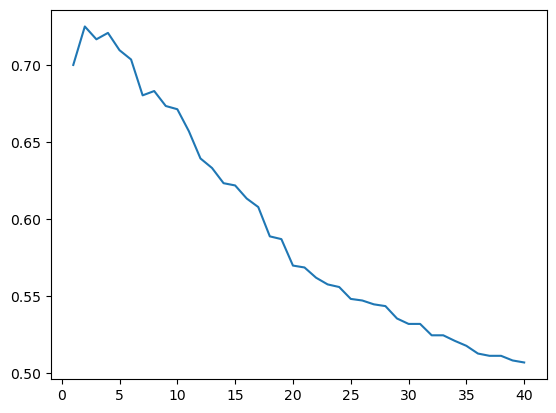

In [154]:
result_dict = defaultdict()
for query in nirs_queries_to_results_first_20.keys():
    result_dict[query] = search(query)
i_list = []
map40_scores_list = []
for i in range(40, 0, -1):
    predicted = defaultdict()
    for query in nirs_queries_to_results_first_20.keys():
        predicted[query] = result_dict[query][:i]
    i_list.append(i)
    map40_scores_list.append(calculate_map_40(predicted, nirs_queries_to_results_first_20))
plt.plot(i_list, map40_scores_list)
plt.show()

# **Testing number of documents to retrieve on test set**

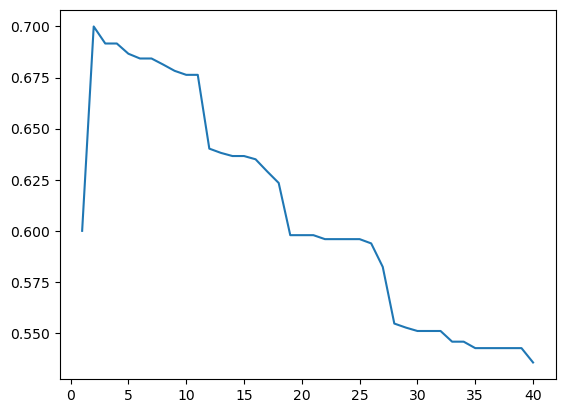

In [155]:
result_dict = defaultdict()
for query in nirs_queries_to_results_last_10.keys():
    result_dict[query] = search(query)
i_list = []
map40_scores_list = []
for i in range(40, 0, -1):
    predicted = defaultdict()
    for query in nirs_queries_to_results_last_10.keys():
        predicted[query] = result_dict[query][:i]
    i_list.append(i)
    map40_scores_list.append(calculate_map_40(predicted, nirs_queries_to_results_last_10))
plt.plot(i_list, map40_scores_list)
plt.show()

Now need to get back to search function and tune it according to the results